In [ ]:
import os
from PIL import Image, ImageDraw, ImageFont

# Убедитесь, что у вас установлен шрифт RoadNumbers2.0.ttf
FONT_PATH = "RoadNumbers2.0.ttf"
OUTPUT_DIR = "templates"

# Буквы и цифры, используемые в российских номерах
SYMBOLS = "DABEKMHOPCTYX0123456789"
IMG_SIZE = (28, 28)
FONT_SIZE = 24

# Создаем директорию для шаблонов
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Загружаем шрифт
try:
    font = ImageFont.truetype(FONT_PATH, FONT_SIZE)
except IOError:
    print(f"Шрифт {FONT_PATH} не найден. Убедитесь, что он находится в текущей директории.")
    exit()

# Генерация изображений для каждого символа
for symbol in SYMBOLS:
    # Создаем пустое изображение с белым фоном
    img = Image.new("L", IMG_SIZE, 255)
    draw = ImageDraw.Draw(img)

    # Получаем размеры текста с использованием Font.getbbox
    text_width, text_height = draw.textbbox((0, 0), symbol, font=font)[2:] # [2:] берёт ширину и высоту

    # Рассчитываем координаты для центрирования текста
    x = (IMG_SIZE[0] - text_width) // 2
    y = (IMG_SIZE[1] - text_height) // 2

    # Рисуем текст
    draw.text((x, y), symbol, font=font, fill=0)

    # Сохраняем изображение
    img.save(os.path.join(OUTPUT_DIR, f"{symbol}.png"))

print(f"Шаблоны сохранены в папке '{OUTPUT_DIR}'.")

Шаблоны сохранены в папке 'templates'.


In [2]:
import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
import cv2
import numpy as np

# Убедитесь, что у вас установлен шрифт RoadNumbers2.0.ttf
FONT_PATH = "RoadNumbers2.0.ttf"
OUTPUT_DIR = "dataset"
CONFIG_FILE = "dataset_config.txt"

# Буквы и цифры, используемые в российских номерах
SYMBOLS = "ABEKMHOPCTYX0123456789"
IMG_SIZE = (28, 28)
FONT_SIZES = [26, 32, 38, 46, 54, 58]
MAX_ROTATION = 15
AUGMENTATIONS = 160

# Создаём директорию для датасета
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Загружаем шрифт
try:
    font = ImageFont.truetype(FONT_PATH, FONT_SIZES[0])
except IOError:
    print(f"Шрифт {FONT_PATH} не найден. Убедитесь, что он находится в текущей директории.")
    exit()

# Функция расширения объектов
def expand_characters(img, kernel_size=(2, 2), iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img_array = np.array(img)
    expanded = cv2.dilate(img_array, kernel, iterations=iterations)
    return Image.fromarray(expanded)

# Функция для добавления случайных разрывов в контуре
def add_random_gaps(img, num_gaps=5, gap_size=5):
    draw = ImageDraw.Draw(img)
    for _ in range(num_gaps):
        x1 = random.randint(0, IMG_SIZE[0] - gap_size)
        y1 = random.randint(0, IMG_SIZE[1] - gap_size)
        x2 = x1 + gap_size
        y2 = y1 + gap_size
        draw.rectangle([x1, y1, x2, y2], fill=255)  # Белый прямоугольник для разрыва
    return img

# Функция для добавления блюра
def apply_blur(img):
    blur_type = random.choice(["box", "gaussian", "motion"])
    if blur_type == "box":
        img = img.filter(ImageFilter.BoxBlur(random.randint(1, 4)))
    elif blur_type == "gaussian":
        img = img.filter(ImageFilter.GaussianBlur(random.randint(1, 3)))
    elif blur_type == "motion":
        kernel_size = random.randint(4, 8)
        kernel_motion_blur = np.zeros((kernel_size, kernel_size))
        kernel_motion_blur[int((kernel_size - 1) / 2), :] = 1
        kernel_motion_blur /= kernel_size
        img_array = cv2.filter2D(np.array(img), -1, kernel_motion_blur)
        img = Image.fromarray(img_array)
    return img

# Функция для добавления шума
def add_noise(img, intensity=30):
    img_array = np.array(img)
    noise = np.random.normal(0, intensity, img_array.shape).astype(np.int32)
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

# Функция для создания аугментаций
def create_augmentations(symbol, font_sizes, max_rotation, augmentations, config_lines):
    for i in range(augmentations):
        for font_size in font_sizes:
            current_font = ImageFont.truetype(FONT_PATH, font_size)

            # Создаём пустое изображение с белым фоном
            img = Image.new("L", IMG_SIZE, 255)
            draw = ImageDraw.Draw(img)

            # Получаем размеры текста с использованием Font.getbbox
            text_bbox = draw.textbbox((0, 0), symbol, font=current_font)
            text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

            # Рассчитываем координаты для центрирования текста
            x = (IMG_SIZE[0] - text_width) // 2 - text_bbox[0]
            y = (IMG_SIZE[1] - text_height) // 2 - text_bbox[1]

            # Рисуем текст
            draw.text((x, y), symbol, font=current_font, fill=0)

            # Для первого прогона символа с данным размером шрифта сохраняем без аугментаций
            if i == 0:
                symbol_dir = os.path.join(OUTPUT_DIR, symbol)
                os.makedirs(symbol_dir, exist_ok=True)
                file_path = os.path.join(symbol_dir, f"{symbol}_{font_size}_{i}.png")
                img.save(file_path)

                config_lines.append(f"{file_path},{symbol}\n")
                continue

            # Случайный поворот изображения
            rotation = random.uniform(-max_rotation, max_rotation)
            img = img.rotate(rotation, expand=False, fillcolor=255)

            # Случайное расширение символов
            if random.random() < 0.5:
                kernel_size = (random.randint(1, 2), random.randint(1, 2))
                iterations = 1
                img = expand_characters(img, kernel_size=kernel_size, iterations=iterations)

            # Случайное добавление разрывов
            if random.random() < 0.75:
                num_gaps = random.randint(1, 5)
                gap_size = random.randint(2, 4)
                img = add_random_gaps(img, num_gaps=num_gaps, gap_size=gap_size)

            if random.random() < 0.25:
                img = ImageOps.invert(img)

            # Случайное добавление блюра
            if random.random() < 0.85:
                img = apply_blur(img)

            # Случайное добавление шума
            if random.random() < 0.1:
                noise_intensity = random.randint(10, 20)
                img = add_noise(img, intensity=noise_intensity)

            # Сохраняем изображение
            symbol_dir = os.path.join(OUTPUT_DIR, symbol)
            os.makedirs(symbol_dir, exist_ok=True)
            file_path = os.path.join(symbol_dir, f"{symbol}_{font_size}_{i}.png")
            img.save(file_path)

            config_lines.append(f"{file_path},{symbol}\n")

# Основной блок генерации датасета
def main():
    config_lines = []

    for symbol in SYMBOLS:
        create_augmentations(symbol, FONT_SIZES, MAX_ROTATION, AUGMENTATIONS, config_lines)

    # Записываем все строки конфигурации одним разом
    config_path = os.path.join(OUTPUT_DIR, CONFIG_FILE)
    with open(config_path, "w") as config:
        config.writelines(config_lines)

    print(f"Датасет сохранен в папке '{OUTPUT_DIR}'.")
    print(f"Конфигурационный файл создан: {CONFIG_FILE}")

if __name__ == "__main__":
    main()


KeyboardInterrupt: 

In [6]:
import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageFilter
import cv2
import numpy as np

# Убедитесь, что у вас установлен шрифт RoadNumbers2.0.ttf
FONT_PATH = "RoadNumbers2.0.ttf"
OUTPUT_DIR = "dataset"
CONFIG_FILE = "dataset_config.txt"

# Буквы и цифры, используемые в российских номерах
SYMBOLS = "ABEKMHOPCTYX0123456789"
IMG_SIZE = (28, 28)
FONT_SIZES = [26, 32, 38, 46, 54, 58]
MAX_ROTATION = 15
AUGMENTATIONS = 160

# Создаём директорию для датасета
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Загружаем шрифт
try:
    font = ImageFont.truetype(FONT_PATH, FONT_SIZES[0])
except IOError:
    print(f"Шрифт {FONT_PATH} не найден. Убедитесь, что он находится в текущей директории.")
    exit()

# Функция расширения объектов
def expand_characters(img, kernel_size=(2, 2), iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    img_array = np.array(img)
    expanded = cv2.dilate(img_array, kernel, iterations=iterations)
    return Image.fromarray(expanded)

# Функция для добавления случайных разрывов в контуре
def add_random_gaps(img, num_gaps=5, gap_size=5):
    draw = ImageDraw.Draw(img)
    for _ in range(num_gaps):
        x1 = random.randint(0, IMG_SIZE[0] - gap_size)
        y1 = random.randint(0, IMG_SIZE[1] - gap_size)
        x2 = x1 + gap_size
        y2 = y1 + gap_size
        draw.rectangle([x1, y1, x2, y2], fill=255)  # Белый прямоугольник для разрыва
    return img

# Функция для добавления блюра
def apply_blur(img):
    blur_type = random.choice(["box", "gaussian", "motion"])
    if blur_type == "box":
        img = img.filter(ImageFilter.BoxBlur(random.randint(1, 4)))
    elif blur_type == "gaussian":
        img = img.filter(ImageFilter.GaussianBlur(random.randint(1, 3)))
    elif blur_type == "motion":
        kernel_size = random.randint(4, 8)
        kernel_motion_blur = np.zeros((kernel_size, kernel_size))
        kernel_motion_blur[int((kernel_size - 1) / 2), :] = 1
        kernel_motion_blur /= kernel_size
        img_array = cv2.filter2D(np.array(img), -1, kernel_motion_blur)
        img = Image.fromarray(img_array)
    return img

# Функция для добавления шума
def add_noise(img, intensity=30):
    img_array = np.array(img)
    noise = np.random.normal(0, intensity, img_array.shape).astype(np.int32)
    noisy_img = np.clip(img_array + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noisy_img)

# Новая функция для смещения изображения
def shift_image(img, max_shift=4):
    """
    Сдвигает изображение на случайное количество пикселей по осям X и Y.

    :param img: PIL Image объект.
    :param max_shift: Максимальное смещение в пикселях по каждой оси.
    :return: Сдвинутое изображение.
    """
    x_shift = random.randint(-max_shift, max_shift)
    y_shift = random.randint(-max_shift, max_shift)
    return img.transform(
        img.size,
        Image.AFFINE,
        (1, 0, x_shift, 0, 1, y_shift),
        fillcolor=255  # Заполнение пустых областей белым цветом
    )

# Функция для создания аугментаций
def create_augmentations(symbol, font_sizes, max_rotation, augmentations, config_lines):
    for i in range(augmentations):
        for font_size in font_sizes:
            current_font = ImageFont.truetype(FONT_PATH, font_size)

            # Создаём пустое изображение с белым фоном
            img = Image.new("L", IMG_SIZE, 255)
            draw = ImageDraw.Draw(img)

            # Получаем размеры текста с использованием Font.getbbox
            text_bbox = draw.textbbox((0, 0), symbol, font=current_font)
            text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

            # Рассчитываем координаты для центрирования текста
            x = (IMG_SIZE[0] - text_width) // 2 - text_bbox[0]
            y = (IMG_SIZE[1] - text_height) // 2 - text_bbox[1]

            # Рисуем текст
            draw.text((x, y), symbol, font=current_font, fill=0)

            # Для первого прогона символа с данным размером шрифта сохраняем без аугментаций
            if i == 0:
                symbol_dir = os.path.join(OUTPUT_DIR, symbol)
                os.makedirs(symbol_dir, exist_ok=True)
                file_path = os.path.join(symbol_dir, f"{symbol}_{font_size}_{i}.png")
                img.save(file_path)

                config_lines.append(f"{file_path},{symbol}\n")
                continue

            # Случайное смещение символа
            if random.random() < 0.7:  # 50% вероятность применения смещения
                img = shift_image(img, max_shift=4)

            # Случайный поворот изображения
            rotation = random.uniform(-max_rotation, max_rotation)
            img = img.rotate(rotation, expand=False, fillcolor=255)

            # Случайное расширение символов
            if random.random() < 0.5:
                kernel_size = (random.randint(1, 2), random.randint(1, 2))
                iterations = 1
                img = expand_characters(img, kernel_size=kernel_size, iterations=iterations)

            # Случайное добавление разрывов
            if random.random() < 0.6:
                num_gaps = random.randint(1, 5)
                gap_size = random.randint(2, 4)
                img = add_random_gaps(img, num_gaps=num_gaps, gap_size=gap_size)

            # Инверсия цветов с вероятностью 25%
            if random.random() < 0.15:
                img = ImageOps.invert(img)

            # Случайное добавление блюра
            if random.random() < 0.85:
                img = apply_blur(img)

            # Случайное добавление шума
            if random.random() < 0.1:
                noise_intensity = random.randint(10, 20)
                img = add_noise(img, intensity=noise_intensity)

            # Сохраняем изображение
            symbol_dir = os.path.join(OUTPUT_DIR, symbol)
            os.makedirs(symbol_dir, exist_ok=True)
            file_path = os.path.join(symbol_dir, f"{symbol}_{font_size}_{i}.png")
            img.save(file_path)

            config_lines.append(f"{file_path},{symbol}\n")

# Основной блок генерации датасета
def main():
    config_lines = []

    for symbol in SYMBOLS:
        create_augmentations(symbol, FONT_SIZES, MAX_ROTATION, AUGMENTATIONS, config_lines)

    # Записываем все строки конфигурации одним разом
    config_path = os.path.join(OUTPUT_DIR, CONFIG_FILE)
    with open(config_path, "w") as config:
        config.writelines(config_lines)

    print(f"Датасет сохранен в папке '{OUTPUT_DIR}'.")
    print(f"Конфигурационный файл создан: {CONFIG_FILE}")

if __name__ == "__main__":
    main()


Датасет сохранен в папке 'dataset'.
Конфигурационный файл создан: dataset_config.txt


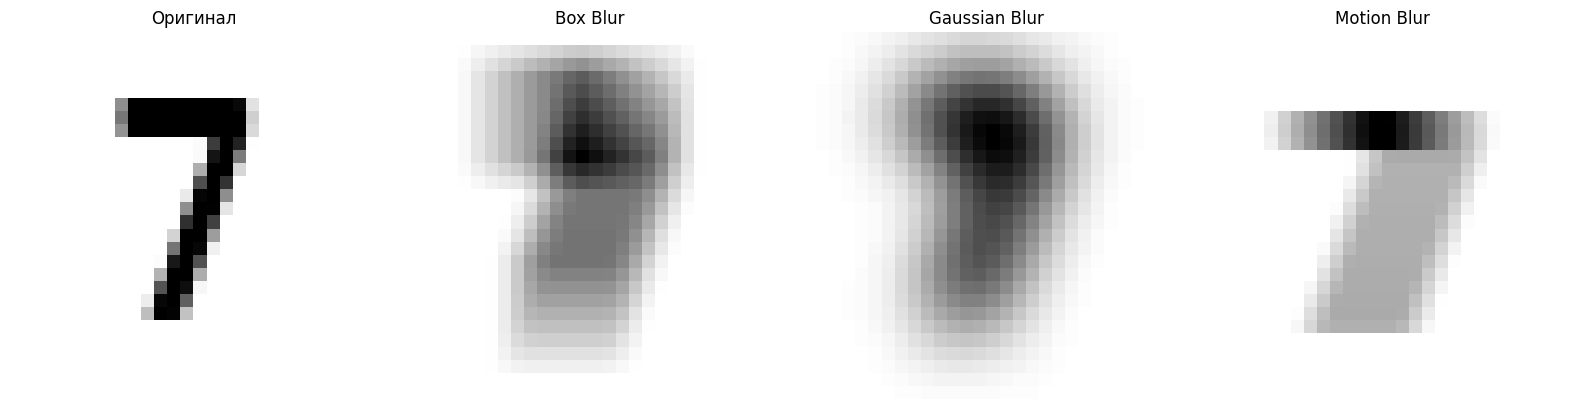

In [17]:
import os
import random
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import matplotlib.pyplot as plt

# Путь к шрифту
FONT_PATH = "RoadNumbers2.0.ttf"  # Убедитесь, что шрифт находится в текущей директории
FONT_SIZE = 26  # Размер шрифта (можно изменить при необходимости)
IMG_SIZE = (28, 28)  # Размер изображения

# Функция для создания изображения с символом
def create_symbol_image(symbol, font_path, font_size, img_size):
    try:
        font = ImageFont.truetype(font_path, font_size)
    except IOError:
        print(f"Шрифт {font_path} не найден. Убедитесь, что он находится в текущей директории.")
        exit()
    
    # Создаём пустое изображение с белым фоном
    img = Image.new("L", img_size, 255)  # "L" для градаций серого
    draw = ImageDraw.Draw(img)
    
    # Получаем размеры текста
    text_bbox = draw.textbbox((0, 0), symbol, font=font)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]
    
    # Рассчитываем координаты для центрирования текста
    x = (img_size[0] - text_width) // 2 - text_bbox[0]
    y = (img_size[1] - text_height) // 2 - text_bbox[1]
    
    # Рисуем текст
    draw.text((x, y), symbol, font=font, fill=0)  # Черный цвет
    
    return img

# Функция для применения блюра
def apply_blur(img, blur_type):
    if blur_type == "box":
        radius = 4
        blurred_img = img.filter(ImageFilter.BoxBlur(radius))
    elif blur_type == "gaussian":
        radius = 3
        blurred_img = img.filter(ImageFilter.GaussianBlur(radius))
    elif blur_type == "motion":
        kernel_size = 8
        # Создаём ядро для motion blur (размытие по горизонтали)
        kernel_motion_blur = np.zeros((kernel_size, kernel_size))
        kernel_motion_blur[int((kernel_size - 1) / 2), :] = 1
        kernel_motion_blur /= kernel_size
        img_array = np.array(img)
        blurred_array = cv2.filter2D(img_array, -1, kernel_motion_blur)
        blurred_img = Image.fromarray(blurred_array)
    else:
        raise ValueError("Неподдерживаемый тип блюра.")
    
    return blurred_img

# Основная функция
def main():
    symbol = '7'  # Цифра для обработки
    blur_types = ["box", "gaussian", "motion"]
    
    # Создаём оригинальное изображение
    original_img = create_symbol_image(symbol, FONT_PATH, FONT_SIZE, IMG_SIZE)
    
    # Применяем каждый тип блюра
    blurred_images = {}
    for blur_type in blur_types:
        blurred_img = apply_blur(original_img, blur_type)
        blurred_images[blur_type] = blurred_img
    
    # Настройка отображения с помощью matplotlib
    num_blurs = len(blur_types)
    plt.figure(figsize=(4 * (num_blurs + 1), 4))  # Размер фигуры зависит от количества изображений
    
    # Отображаем оригинальное изображение
    plt.subplot(1, num_blurs + 1, 1)
    plt.imshow(original_img, cmap='gray')
    plt.title("Оригинал")
    plt.axis('off')
    
    # Отображаем размытые изображения
    for idx, blur_type in enumerate(blur_types, start=2):
        plt.subplot(1, num_blurs + 1, idx)
        plt.imshow(blurred_images[blur_type], cmap='gray')
        plt.title(f"{blur_type.capitalize()} Blur")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image

DATASET_DIR = "dataset"
SAVE_PATH = "best_model_3.pth"
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CLASSES = "ABEKMHOPCTYX0123456789"
NUM_CLASSES = len(CLASSES)
CLASS_TO_IDX = {char: idx for idx, char in enumerate(CLASSES)}
IDX_TO_CLASS = {idx: char for char, idx in CLASS_TO_IDX.items()}

In [10]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

class LicensePlateDataset(Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.data = []
        self.transform = transform
        with open(os.path.join(dataset_dir, "dataset_config.txt"), "r") as file:
            for line in file:
                path, label = line.strip().split(",")
                self.data.append((path, CLASS_TO_IDX[label]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("L")
        if self.transform:
            image = self.transform(image)
        return image, label


transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

full_dataset = LicensePlateDataset(DATASET_DIR, transform=transform)

indices = list(range(len(full_dataset)))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
test_dataset = Subset(full_dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Размер тренировочного набора: {len(train_dataset)}")
print(f"Размер тестового набора: {len(test_dataset)}")


Размер тренировочного набора: 16896
Размер тестового набора: 4224


In [43]:
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # Увеличиваем количество фильтров
            nn.LeakyReLU(negative_slope=0.1),  # Используем LeakyReLU вместо ReLU
            nn.BatchNorm2d(32),  # Нормализация
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),  # Используем ELU вместо ReLU
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),  # Используем SiLU (Swish) вместо ReLU
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 3 * 3, 256),
            nn.GELU(),  # Используем GELU для полносвязного слоя
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = SimpleCNN(len(CLASSES)).to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
#criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
#optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

#optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
from tqdm import tqdm

best_accuracy = 0.0
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    train_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_bar.set_postfix(loss=f"{running_loss/len(train_loader):.4f}", acc=f"{100 * correct_train / total_train:.2f}%")

    train_accuracy = 100 * correct_train / total_train
    print(f"Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in test_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"Best model saved with test accuracy: {best_accuracy:.2f}%")

print("Обучение завершено.")


Epoch [1/30]


Training:   0%|          | 0/528 [00:00<?, ?it/s]

Train Loss: 2.2562, Train Accuracy: 41.64%


Test Loss: 1.5400, Test Accuracy: 72.47%
Best model saved with test accuracy: 72.47%
Epoch [2/30]


Train Loss: 1.4775, Train Accuracy: 72.54%


Test Loss: 1.2487, Test Accuracy: 82.43%
Best model saved with test accuracy: 82.43%
Epoch [3/30]


Train Loss: 1.2714, Train Accuracy: 80.63%


Test Loss: 1.1178, Test Accuracy: 86.65%
Best model saved with test accuracy: 86.65%
Epoch [4/30]


Train Loss: 1.1700, Train Accuracy: 84.59%


Test Loss: 1.0693, Test Accuracy: 88.02%
Best model saved with test accuracy: 88.02%
Epoch [5/30]


Train Loss: 1.0998, Train Accuracy: 87.51%


Test Loss: 1.0128, Test Accuracy: 89.89%
Best model saved with test accuracy: 89.89%
Epoch [6/30]


Train Loss: 1.0531, Train Accuracy: 89.01%


Test Loss: 0.9741, Test Accuracy: 90.77%
Best model saved with test accuracy: 90.77%
Epoch [7/30]


Train Loss: 1.0165, Train Accuracy: 90.26%


Test Loss: 0.9434, Test Accuracy: 92.14%
Best model saved with test accuracy: 92.14%
Epoch [8/30]


Train Loss: 0.9889, Train Accuracy: 91.57%


Test Loss: 0.9299, Test Accuracy: 93.42%
Best model saved with test accuracy: 93.42%
Epoch [9/30]


Train Loss: 0.9668, Train Accuracy: 92.20%


Test Loss: 0.9245, Test Accuracy: 92.57%
Epoch [10/30]


Train Loss: 0.9427, Train Accuracy: 92.90%


Test Loss: 0.9001, Test Accuracy: 92.87%
Epoch [11/30]


Train Loss: 0.9336, Train Accuracy: 92.98%


Test Loss: 0.8980, Test Accuracy: 93.11%
Epoch [12/30]


Train Loss: 0.9161, Train Accuracy: 93.77%


Test Loss: 0.8720, Test Accuracy: 94.34%
Best model saved with test accuracy: 94.34%
Epoch [13/30]


Train Loss: 0.9031, Train Accuracy: 94.06%


Test Loss: 0.8702, Test Accuracy: 93.92%
Epoch [14/30]


Train Loss: 0.8949, Train Accuracy: 94.36%


Test Loss: 0.8564, Test Accuracy: 94.79%
Best model saved with test accuracy: 94.79%
Epoch [15/30]


Train Loss: 0.8834, Train Accuracy: 94.86%


Test Loss: 0.8516, Test Accuracy: 94.77%
Epoch [16/30]


Train Loss: 0.8761, Train Accuracy: 94.99%


Test Loss: 0.8566, Test Accuracy: 94.11%
Epoch [17/30]


Train Loss: 0.8690, Train Accuracy: 95.05%


Test Loss: 0.8463, Test Accuracy: 94.86%
Best model saved with test accuracy: 94.86%
Epoch [18/30]


Train Loss: 0.8607, Train Accuracy: 95.47%


Test Loss: 0.8430, Test Accuracy: 94.77%
Epoch [19/30]


Train Loss: 0.8550, Train Accuracy: 95.57%


Test Loss: 0.8356, Test Accuracy: 94.84%
Epoch [20/30]


Train Loss: 0.8473, Train Accuracy: 95.70%


Test Loss: 0.8284, Test Accuracy: 94.72%
Epoch [21/30]


Train Loss: 0.8450, Train Accuracy: 95.86%


Test Loss: 0.8287, Test Accuracy: 95.08%
Best model saved with test accuracy: 95.08%
Epoch [22/30]


Train Loss: 0.8378, Train Accuracy: 96.04%


Test Loss: 0.8208, Test Accuracy: 95.36%
Best model saved with test accuracy: 95.36%
Epoch [23/30]


Train Loss: 0.8315, Train Accuracy: 96.20%


Test Loss: 0.8261, Test Accuracy: 95.31%
Epoch [24/30]


Train Loss: 0.8314, Train Accuracy: 96.29%


Test Loss: 0.8259, Test Accuracy: 95.38%
Best model saved with test accuracy: 95.38%
Epoch [25/30]


Train Loss: 0.8240, Train Accuracy: 96.51%


Test Loss: 0.8189, Test Accuracy: 94.91%
Epoch [26/30]


Train Loss: 0.8187, Train Accuracy: 96.73%


Test Loss: 0.8071, Test Accuracy: 95.41%
Best model saved with test accuracy: 95.41%
Epoch [27/30]


Train Loss: 0.8145, Train Accuracy: 96.63%


Test Loss: 0.8207, Test Accuracy: 95.27%
Epoch [28/30]


Train Loss: 0.8134, Train Accuracy: 96.76%


Test Loss: 0.8146, Test Accuracy: 95.50%
Best model saved with test accuracy: 95.50%
Epoch [29/30]


Train Loss: 0.8097, Train Accuracy: 96.77%


Test Loss: 0.8127, Test Accuracy: 95.12%
Epoch [30/30]


Train Loss: 0.8054, Train Accuracy: 96.92%


Test Loss: 0.8038, Test Accuracy: 95.55%
Best model saved with test accuracy: 95.55%
Обучение завершено.


In [22]:
import torch.nn as nn
import torch.optim as optim

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

class EnhancedCNN(nn.Module):
    def __init__(self, num_classes):
        super(EnhancedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            ResidualBlock(32, 64),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            ResidualBlock(64, 128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),

            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.GELU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = EnhancedCNN(len(CLASSES)).to(DEVICE)
criterion = nn.CrossEntropyLoss()  # Или FocalLoss(), если необходимо
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Предполагается, что следующие переменные уже определены:
# model, train_loader, test_loader, DEVICE, EPOCHS, SAVE_PATH, CLASSES

# Определение функции ранней остановки
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        """
        Args:
            patience (int): Количество эпох без улучшения перед остановкой.
            verbose (bool): Выводить сообщения о сохранении модели.
            delta (float): Минимальное улучшение для учёта.
        """
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.best_accuracy = 0.0

    def __call__(self, score, model):
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(score, model)
        elif score < self.best_score + self.delta:
            self.patience -= 1
            if self.verbose:
                print(f"Ранняя остановка через {self.patience} эпох(и).")
            if self.patience <= 0:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(score, model)
            self.patience = 10  # Сброс patience

    def save_checkpoint(self, score, model):
        if self.verbose:
            print(f"Улучшение найдено: {score:.4f}. Сохранение модели...")
        torch.save(model.state_dict(), SAVE_PATH)
        self.best_accuracy = score

# Инициализация функции потерь, оптимизатора и планировщика
criterion = nn.CrossEntropyLoss()  # Или используйте FocalLoss(), если необходимо
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
early_stopping = EarlyStopping(patience=10, verbose=True)

best_accuracy = 0.0

for epoch in range(1, EPOCHS + 1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    print(f"\nEpoch [{epoch}/{EPOCHS}]")
    train_bar = tqdm(train_loader, desc="Training", leave=False)

    for images, labels in train_bar:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_loss = running_loss / (train_bar.n + 1)
        current_acc = 100 * correct_train / total_train
        train_bar.set_postfix(loss=f"{current_loss:.4f}", acc=f"{current_acc:.2f}%")

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")

    # Валидация
    model.eval()
    correct_test = 0
    total_test = 0
    test_loss = 0.0

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc="Testing", leave=False)
        for images, labels in test_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Обновление планировщика
    scheduler.step()

    # Проверка и обновление лучших результатов
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save(model.state_dict(), SAVE_PATH)
        print(f"Best model saved with test accuracy: {best_accuracy:.2f}%")

    # Применение ранней остановки
    early_stopping(test_accuracy, model)
    if early_stopping.early_stop:
        print("Ранняя остановка активирована. Обучение завершено.")
        break

print("Обучение завершено.")



Epoch [1/10]


Train Loss: 2.9490, Train Accuracy: 9.62%


Test Loss: 2.2683, Test Accuracy: 31.25%
Best model saved with test accuracy: 31.25%
Улучшение найдено: 31.2500. Сохранение модели...

Epoch [2/10]


Train Loss: 1.6123, Train Accuracy: 48.72%


Test Loss: 0.4703, Test Accuracy: 89.68%
Best model saved with test accuracy: 89.68%
Улучшение найдено: 89.6780. Сохранение модели...

Epoch [3/10]


Train Loss: 0.6699, Train Accuracy: 79.42%


Test Loss: 0.2471, Test Accuracy: 93.47%
Best model saved with test accuracy: 93.47%
Улучшение найдено: 93.4659. Сохранение модели...

Epoch [4/10]


Train Loss: 0.4096, Train Accuracy: 87.37%


Test Loss: 0.1863, Test Accuracy: 95.03%
Best model saved with test accuracy: 95.03%
Улучшение найдено: 95.0284. Сохранение модели...

Epoch [5/10]


Train Loss: 0.2973, Train Accuracy: 91.12%


Test Loss: 0.1082, Test Accuracy: 96.83%
Best model saved with test accuracy: 96.83%
Улучшение найдено: 96.8277. Сохранение модели...

Epoch [6/10]


Train Loss: 0.2404, Train Accuracy: 92.58%


Test Loss: 0.1003, Test Accuracy: 97.44%
Best model saved with test accuracy: 97.44%
Улучшение найдено: 97.4432. Сохранение модели...

Epoch [7/10]


Train Loss: 0.1923, Train Accuracy: 94.24%


Test Loss: 0.0840, Test Accuracy: 97.63%
Best model saved with test accuracy: 97.63%
Улучшение найдено: 97.6326. Сохранение модели...

Epoch [8/10]


Train Loss: 0.1699, Train Accuracy: 94.70%


Test Loss: 0.0862, Test Accuracy: 97.59%
Ранняя остановка через 9 эпох(и).

Epoch [9/10]


Train Loss: 0.1481, Train Accuracy: 95.53%


Test Loss: 0.0703, Test Accuracy: 97.54%
Ранняя остановка через 8 эпох(и).

Epoch [10/10]


Train Loss: 0.1311, Train Accuracy: 95.96%


Test Loss: 0.0719, Test Accuracy: 97.82%
Best model saved with test accuracy: 97.82%
Улучшение найдено: 97.8220. Сохранение модели...
Обучение завершено.


In [27]:
import torch
from collections import defaultdict

def calculate_error_statistics(model, loader, device):
    """
    Вычисляет общую статистику ошибок для датасета (train_loader/test_loader).

    :param model: обученная модель
    :param loader: DataLoader для вычисления статистики
    :param device: устройство ('cuda' или 'cpu')
    :return: словарь с количеством ошибок для каждого класса
    """
    model.eval()
    error_stats = defaultdict(int)  # Хранение ошибок для каждого класса
    total_samples = defaultdict(int)  # Общее количество образцов для каждого класса

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            predictions = torch.argmax(outputs, dim=1)

            for pred, target in zip(predictions, targets):
                total_samples[target.item()] += 1
                if pred.item() != target.item():
                    error_stats[target.item()] += 1

    error_percentages = {
        cls: (errors / total_samples[cls] * 100) if total_samples[cls] > 0 else 0
        for cls, errors in error_stats.items()
    }

    return error_stats, error_percentages

train_errors, train_error_percentages = calculate_error_statistics(model, train_loader, DEVICE)
test_errors, test_error_percentages = calculate_error_statistics(model, test_loader, DEVICE)

print("Train Error Statistics:", train_errors)
print("Train Error Percentages:", train_error_percentages)
print("Test Error Statistics:", test_errors)
print("Test Error Percentages:", test_error_percentages)


Train Error Statistics: defaultdict(<class 'int'>, {6: 19, 12: 7, 1: 8, 10: 8, 7: 4, 20: 8, 3: 6, 2: 8, 9: 4, 19: 9, 11: 8, 16: 9, 17: 8, 0: 5, 13: 4, 18: 8, 21: 2, 8: 1, 5: 5, 4: 7, 14: 1})
Train Error Percentages: {6: 2.5299600532623168, 12: 0.8962868117797695, 1: 1.0062893081761006, 10: 1.0296010296010296, 7: 0.5161290322580645, 20: 1.0430247718383312, 3: 0.7905138339920948, 2: 1.06951871657754, 9: 0.5221932114882507, 19: 1.1583011583011582, 11: 1.0309278350515463, 16: 1.1450381679389312, 17: 1.0610079575596816, 0: 0.628140703517588, 13: 0.5263157894736842, 18: 1.0526315789473684, 21: 0.26246719160104987, 8: 0.13315579227696406, 5: 0.6459948320413437, 4: 0.9283819628647214, 14: 0.12919896640826875}
Test Error Statistics: defaultdict(<class 'int'>, {10: 2, 2: 3, 5: 3, 16: 4, 17: 4, 20: 8, 19: 3, 14: 1, 6: 5, 11: 3, 13: 4, 0: 3, 1: 5, 15: 2, 21: 3, 4: 3, 9: 4, 18: 2, 7: 3, 12: 2})
Test Error Percentages: {10: 1.092896174863388, 2: 1.4150943396226416, 5: 1.6129032258064515, 16: 2.29885

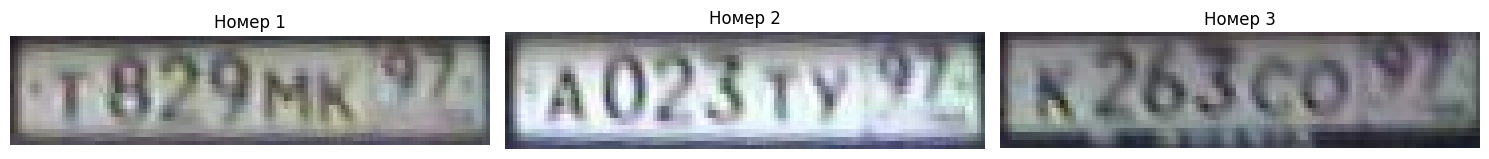

In [28]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Функция для упорядочивания точек в определенном порядке: верхний левый, верхний правый, нижний правый, нижний левый
def order_points(pts):
    """
    Упорядочивает точки в порядке:
    верхний левый, верхний правый, нижний правый, нижний левый
    """
    rect = np.zeros((4, 2), dtype="float32")

    # Сумма координат для нахождения верхнего левого и нижнего правого углов
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # верхний левый
    rect[2] = pts[np.argmax(s)]  # нижний правый

    # Разница координат для нахождения верхнего правого и нижнего левого углов
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # верхний правый
    rect[3] = pts[np.argmax(diff)]  # нижний левый

    return rect

# Функция для получения перспективного преобразования
def get_transform(image, pts):
    """
    Применяет перспективное преобразование к области, определенной точками pts в изображении.
    Возвращает обрезанное и преобразованное изображение номерного знака.
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    # Вычисляем ширину нового изображения
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    # Вычисляем высоту нового изображения
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    # Определяем точки назначения для преобразования
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    # Вычисляем матрицу перспективного преобразования
    M = cv2.getPerspectiveTransform(rect, dst)

    # Применяем перспективное преобразование
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

# Функция для получения преобразованного номерного знака
def get_transformed_plate(image, bbox):
    """
    Выполняет перспективное преобразование для извлечения номерного знака из изображения.
    """
    plate = get_transform(image, bbox)
    return plate

# Список путей к изображениям
images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg']

processed_plates = []

for img_path in images:
    image = cv2.imread(img_path)
    
    if image is None:
        print(f"Не удалось загрузить изображение по пути: {img_path}")
        processed_plates.append(None)
        continue

    # Преобразуем изображение в оттенки серого
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Применяем пороговое значение для выделения контуров
    ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
    
    # Находим контуры на изображении
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plate_found = False  # Флаг для отслеживания обнаружения номерного знака

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspectRatio = float(w) / h

        # Фильтруем контуры по соотношению сторон и площади
        if aspectRatio >= 3 and area > 600:
            approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
            
            # Проверяем, имеет ли контур 4 угла и находится ли он достаточно далеко от края
            if len(approx) <= 4 and x > 15:
                # Получаем минимальный ограничивающий прямоугольник с поворотом
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.intp(box)

                # Применяем перспективное преобразование для извлечения номерного знака
                plate = get_transformed_plate(image, box)

                processed_plates.append(plate)
                plate_found = True
                break  # Выходим из цикла после нахождения первого подходящего контура

    if not plate_found:
        print(f"Номерной знак не найден на изображении: {img_path}")
        processed_plates.append(None)

# Отображаем обработанные номерные знаки с помощью Matplotlib
num_plates = len(processed_plates)

# Определяем количество столбцов и строк для отображения
cols = min(num_plates, 3)  # Ограничиваем до 3 столбцов
rows = (num_plates + cols - 1) // cols  # Вычисляем необходимое количество строк

fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
axs = axs.flatten() if num_plates > 1 else [axs]

for i, rotated_plate in enumerate(processed_plates):
    ax = axs[i]
    if rotated_plate is not None:
        # Проверяем, является ли изображение цветным
        if len(rotated_plate.shape) == 3:
            rotated_plate_rgb = cv2.cvtColor(rotated_plate, cv2.COLOR_BGR2RGB)
            ax.imshow(rotated_plate_rgb)
        else:
            ax.imshow(rotated_plate, cmap='gray')
    else:
        # Отображаем сообщение, если номерной знак не найден
        ax.text(0.5, 0.5, 'Номер не найден', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
    
    ax.set_title(f'Номер {i+1}')
    ax.axis('off')

# Скрываем неиспользуемые подграфики, если они есть
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


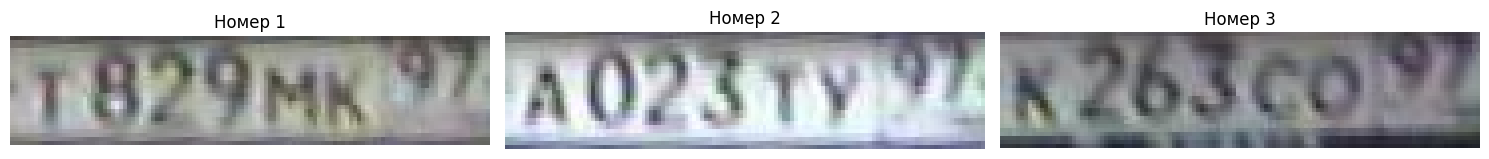

In [6]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def order_points(pts):
    """
    Упорядочивает точки в порядке:
    верхний левый, верхний правый, нижний правый, нижний левый
    """
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)] 
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)] 
    rect[3] = pts[np.argmax(diff)] 

    return rect

def get_transform(image, pts, padding=0.1):
    """
    Применяет перспективное преобразование к области, определенной точками pts в изображении.
    Уменьшает область захвата на заданный процент (padding).
    Возвращает обрезанное и преобразованное изображение номерного знака.
    
    :param image: Исходное изображение
    :param pts: Точки контура номерного знака (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    """
    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))

    center = np.mean(rect, axis=0)

    vectors = rect - center

    rect_shrinked = rect - vectors * padding

    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")

    M = cv2.getPerspectiveTransform(rect_shrinked, dst)

    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))

    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    """
    Выполняет перспективное преобразование для извлечения номерного знака из изображения.
    Уменьшает область захвата на заданный процент (padding).
    
    :param image: Исходное изображение
    :param bbox: Координаты ограничивающего прямоугольника (4 точки)
    :param padding: Процент уменьшения области захвата (например, 0.1 для 10%)
    :return: Преобразованное изображение номерного знака
    """
    plate = get_transform(image, bbox, padding)
    return plate

images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg']

processed_plates = []

for img_path in images:
    image = cv2.imread(img_path)
    
    if image is None:
        print(f"Не удалось загрузить изображение по пути: {img_path}")
        processed_plates.append(None)
        continue

    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    plate_found = False 

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspectRatio = float(w) / h

        if aspectRatio >= 3 and area > 600:
            approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
            
            if len(approx) <= 4 and x > 15:
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.intp(box)

                
                plate = get_transformed_plate(image, box, padding=0.1) 

                processed_plates.append(plate)
                plate_found = True
                break 

    if not plate_found:
        print(f"Номерной знак не найден на изображении: {img_path}")
        processed_plates.append(None)

num_plates = len(processed_plates)

cols = min(num_plates, 3)
rows = (num_plates + cols - 1) // cols 

fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
if num_plates == 1:
    axs = [axs] 
else:
    axs = axs.flatten()

for i, rotated_plate in enumerate(processed_plates):
    ax = axs[i]
    if rotated_plate is not None:
        if len(rotated_plate.shape) == 3:
            rotated_plate_rgb = cv2.cvtColor(rotated_plate, cv2.COLOR_BGR2RGB)
            ax.imshow(rotated_plate_rgb)
        else:
            ax.imshow(rotated_plate, cmap='gray')
    else:
        ax.text(0.5, 0.5, 'Номер не найден', horizontalalignment='center', verticalalignment='center', fontsize=12, color='red')
    
    ax.set_title(f'Номер {i+1}')
    ax.axis('off')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()


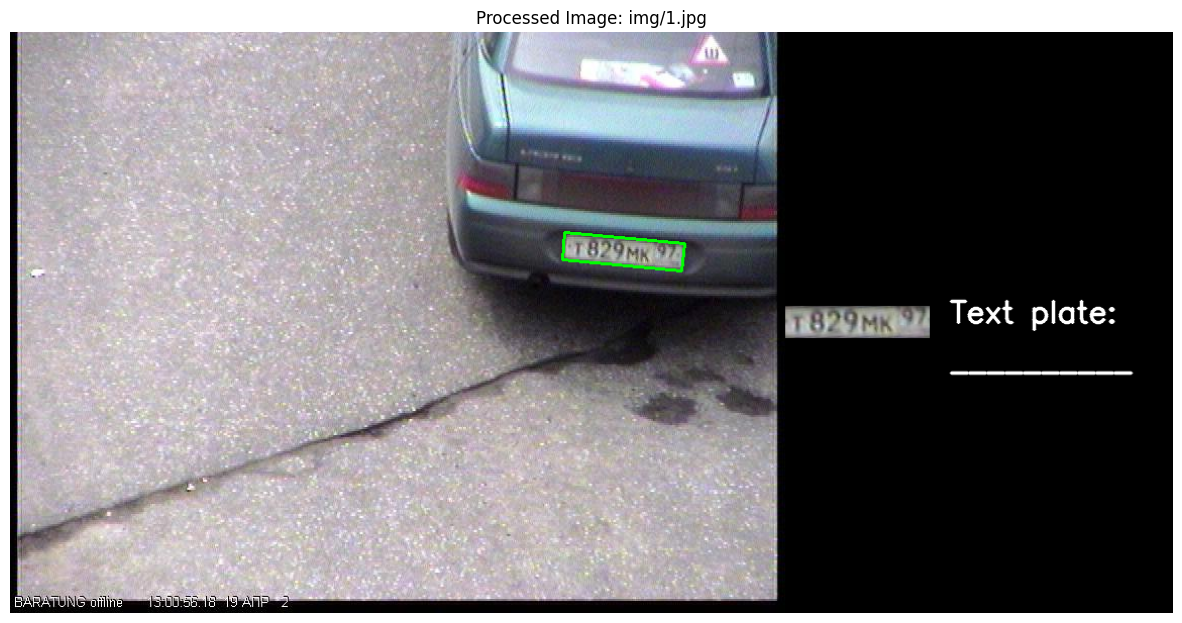

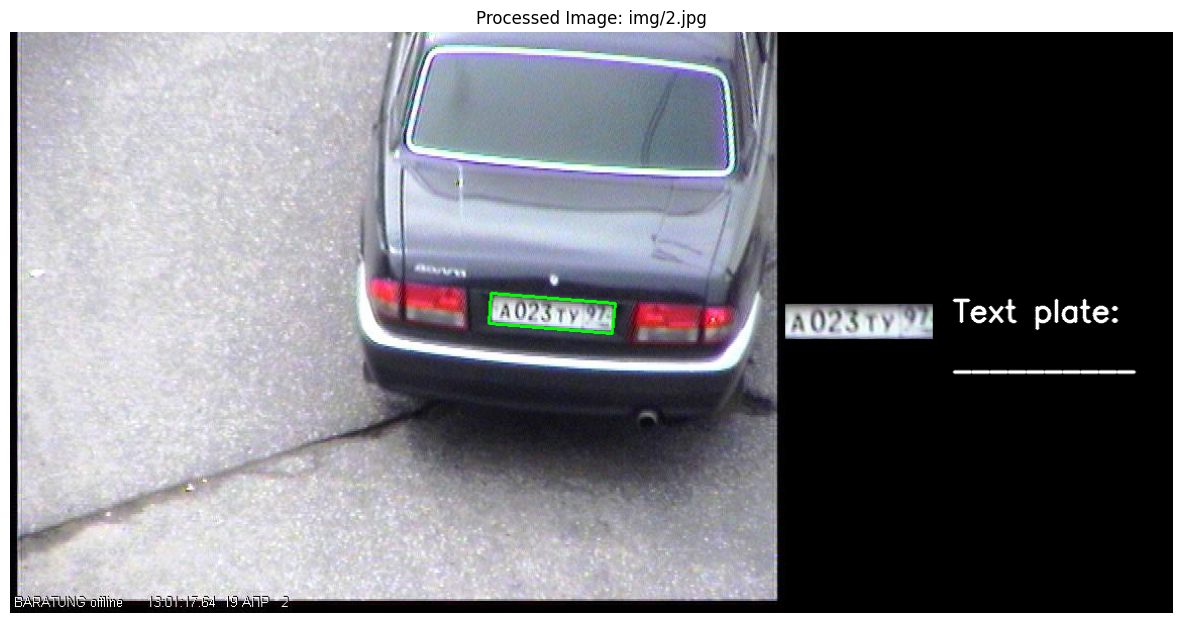

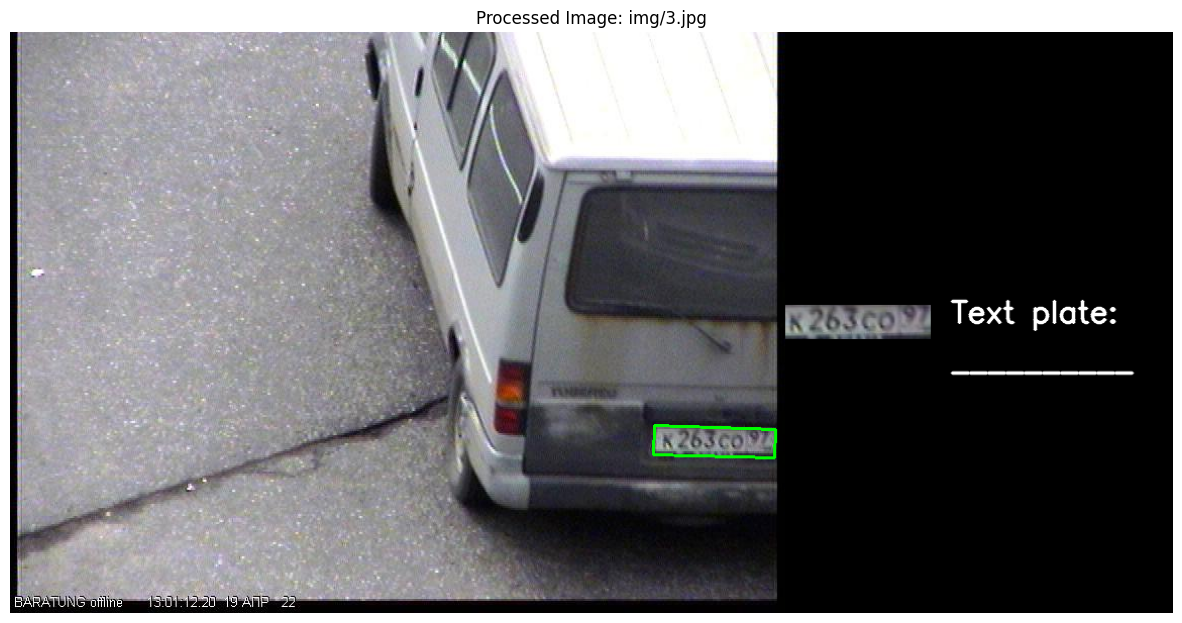

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def get_transform(image, pts, padding=0.1):
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    widthA = np.linalg.norm(br - bl)
    widthB = np.linalg.norm(tr - tl)
    maxWidth = max(int(widthA), int(widthB))
    heightA = np.linalg.norm(tr - br)
    heightB = np.linalg.norm(tl - bl)
    maxHeight = max(int(heightA), int(heightB))
    center = np.mean(rect, axis=0)
    vectors = rect - center
    rect_shrinked = rect - vectors * padding
    rect_shrinked[:, 0] = np.clip(rect_shrinked[:, 0], 0, image.shape[1] - 1)
    rect_shrinked[:, 1] = np.clip(rect_shrinked[:, 1], 0, image.shape[0] - 1)
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(rect_shrinked, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    return warped

def get_transformed_plate(image, bbox, padding=0.1):
    plate = get_transform(image, bbox, padding)
    return plate

def process_and_display_plate(image_path, padding=0.1):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image at path: {image_path}")
        return
    output_image = image.copy()
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(img_gray, 100, 200, cv2.THRESH_TOZERO_INV)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    plate_found = False
    plate_image = None
    plate_box = None
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        aspectRatio = float(w) / h
        if aspectRatio >= 3 and area > 600:
            approx = cv2.approxPolyDP(cnt, 0.05 * cv2.arcLength(cnt, True), True)
            if len(approx) <= 4 and x > 15:
                rect = cv2.minAreaRect(cnt)
                box = cv2.boxPoints(rect)
                box = np.intp(box)
                plate_image = get_transformed_plate(image, box, padding)
                plate_found = True
                plate_box = box
                break
    if plate_found:
        cv2.polylines(output_image, [plate_box], isClosed=True, color=(0, 255, 0), thickness=2)
    height, width = image.shape[:2]
    black_space_width = width // 2
    black_space = np.zeros((height, black_space_width, 3), dtype=np.uint8)
    if plate_found and plate_image is not None:
        plate_height, plate_width = plate_image.shape[:2]
        scale_factor = min(black_space_width / (plate_width + 200), height / plate_height)
        new_plate_width = int(plate_width * scale_factor)
        new_plate_height = int(plate_height * scale_factor)
        resized_plate = cv2.resize(plate_image, (new_plate_width, new_plate_height), interpolation=cv2.INTER_AREA)
        y_offset = (height - new_plate_height) // 2
        black_space[y_offset:y_offset + new_plate_height, 0:new_plate_width] = resized_plate
        placeholder_text = "Text plate:"
        decoded_text = "__________"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (255, 255, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        cv2.putText(black_space, placeholder_text, (new_plate_width + 20, y_offset + new_plate_height // 2), 
                    font, font_scale, font_color, thickness, line_type)
        cv2.putText(black_space, decoded_text, (new_plate_width + 20, y_offset + new_plate_height // 2 + 50), 
                    font, font_scale, font_color, thickness, line_type)
    else:
        placeholder_text = "Not found."
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 1
        font_color = (0, 0, 255)
        thickness = 2
        line_type = cv2.LINE_AA
        text_size, _ = cv2.getTextSize(placeholder_text, font, font_scale, thickness)
        text_x = (black_space_width - text_size[0]) // 2
        text_y = height // 2
        cv2.putText(black_space, placeholder_text, (text_x, text_y), 
                    font, font_scale, font_color, thickness, line_type)
    combined_image = np.hstack((output_image, black_space))
    combined_image_rgb = cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(15, 10))
    plt.imshow(combined_image_rgb)
    plt.axis('off')
    plt.title(f'Processed Image: {image_path}')
    plt.show()

images = ['img/1.jpg', 'img/2.jpg', 'img/3.jpg']

for img_path in images:
    process_and_display_plate(img_path, padding=0.1)


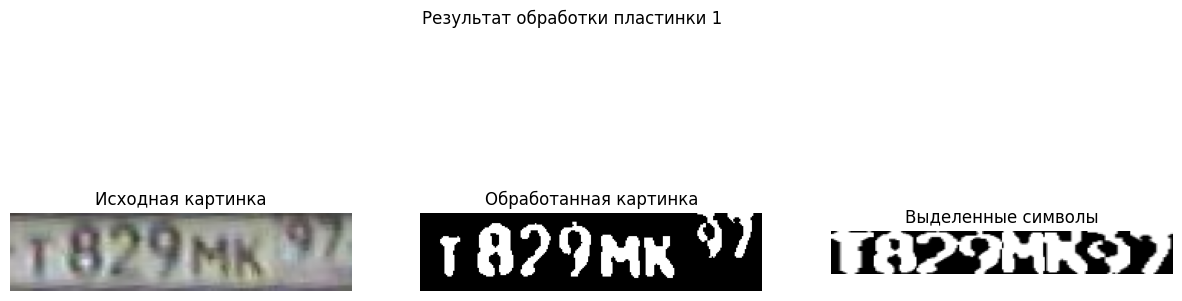

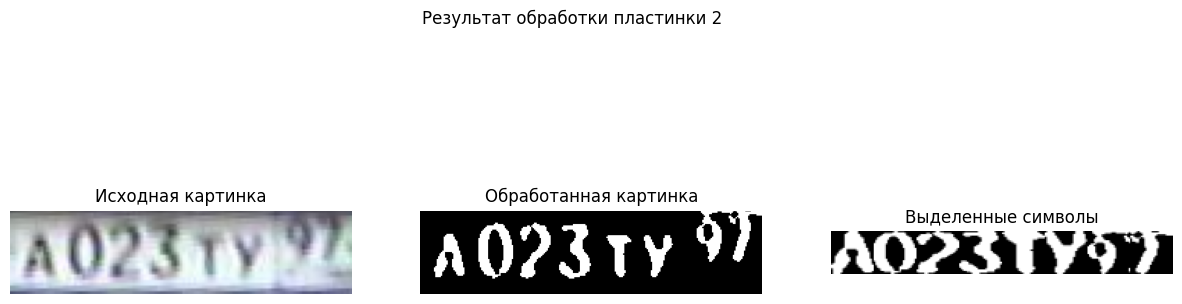

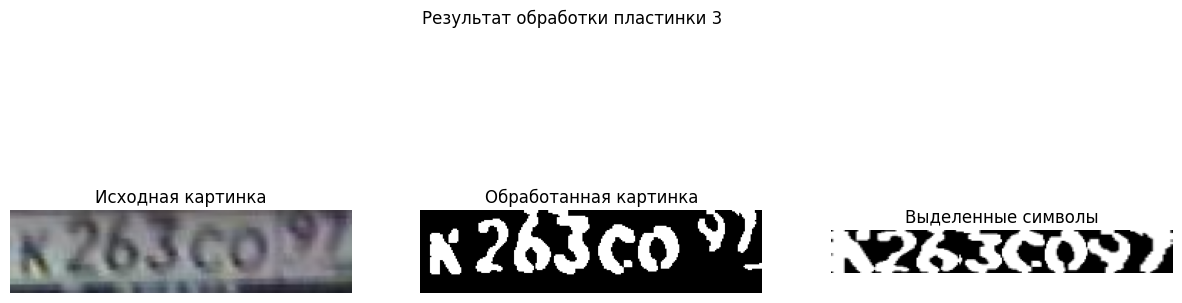

In [31]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Функция удаления мелких объектов
def bwareaopen(imgBW, areaPixels):
    imgBWcopy = imgBW.copy()
    contours, _ = cv2.findContours(imgBWcopy, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    for contour in contours:
        if cv2.contourArea(contour) < areaPixels:
            cv2.drawContours(imgBWcopy, [contour], -1, 0, -1)
    return imgBWcopy

# Функция расширения объектов
def expand_characters(img, kernel_size=(2, 2), iterations=1):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    return cv2.dilate(img, kernel, iterations=iterations)

def selective_dilation(image, distance_threshold=10, iterations=1):
    """
    Выполняет "наращивание" (дилатацию) символов, чтобы соединить близкие контуры.
    
    :param image: Бинарное изображение.
    :param distance_threshold: Максимальное расстояние между контурами для их соединения.
    :param iterations: Количество итераций для расширения.
    :return: Обработанное изображение.
    """
    # Копируем изображение
    image_copy = image.copy()

    # Находим контуры
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Создаём маску для временного соединения контуров
    temp_mask = np.zeros_like(image)

    for i, cnt1 in enumerate(contours):
        for j, cnt2 in enumerate(contours):
            if i != j:  # Сравниваем контуры только с другими
                # Находим минимальное расстояние между точками двух контуров
                min_distance = float("inf")
                for pt1 in cnt1:
                    for pt2 in cnt2:
                        dist = np.linalg.norm(np.array(pt1[0]) - np.array(pt2[0]))
                        if dist < min_distance:
                            min_distance = dist

                # Если расстояние меньше порога, соединяем контуры
                if min_distance < distance_threshold:
                    # Рисуем оба контура на временной маске
                    cv2.drawContours(temp_mask, [cnt1], -1, 255, thickness=-1)
                    cv2.drawContours(temp_mask, [cnt2], -1, 255, thickness=-1)

    # Выполняем дилатацию только на временной маске
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_mask = cv2.dilate(temp_mask, kernel, iterations=iterations)

    # Объединяем исходное изображение с обработанной маской
    result = cv2.bitwise_or(image_copy, dilated_mask)

    return result

def imclearborder(imgBW, radius=1):
    """
    Удаляет только те объекты, которые непосредственно касаются границ изображения,
    если у них нет точек в пределах 30% от верхней или нижней границы.
    
    :param imgBW: Бинарное изображение (чёрно-белое, 0 и 255).
    :param radius: Расстояние от границы, в пределах которого объект считается касающимся.
    :return: Изображение с удалёнными объектами, касающимися границ.
    """
    imgBWcopy = imgBW.copy()

    # Находим контуры
    contours, _ = cv2.findContours(imgBWcopy.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    imgRows, imgCols = imgBW.shape

    # Границы для проверки: 30% сверху и снизу
    top_limit = int(imgRows * 0.3)
    bottom_limit = int(imgRows * 0.7)

    # Список контуров, которые касаются границы
    contourList = []

    for idx, cnt in enumerate(contours):
        remove_contour = True  # Предположим, что контур нужно удалить
        for pt in cnt:
            rowCnt = pt[0][1]  # y-координата
            colCnt = pt[0][0]  # x-координата

            # Проверка на касание границы
            check1 = (rowCnt >= 0 and rowCnt < radius) or (rowCnt >= imgRows - radius and rowCnt < imgRows)
            check2 = (colCnt >= 0 and colCnt < radius) or (colCnt >= imgCols - radius and colCnt < imgCols)

            # Если точка находится в пределах 30% от верха или низа, не удаляем контур
            if top_limit <= rowCnt <= bottom_limit:
                remove_contour = False
                break

            if check1 or check2:
                continue  # Проверяем следующую точку

        if remove_contour:
            contourList.append(idx)

    # Удаляем найденные контуры
    for idx in contourList:
        cv2.drawContours(imgBWcopy, contours, idx, (0, 0, 0), -1)

    return imgBWcopy



# Основная функция обработки одной пластины
def process_plate(plate):
    # Преобразование в градации серого
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Увеличение размера для улучшения качества
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Фильтрация и бинаризация
    gray = cv2.GaussianBlur(resized_plate, (3, 3), 0)
    thresh = cv2.adaptiveThreshold(gray, 255,
                                   cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 41, 10)

    # Удаление мелких областей
    #expanded_image = expand_characters(thresh, kernel_size=(2, 2), iterations=1)
    thresh = imclearborder(thresh, 5)
    expanded_image = selective_dilation(thresh, distance_threshold=7, iterations=1)
    processed_plate = bwareaopen(expanded_image, 20)

    # Поиск контуров символов
    contours, _ = cv2.findContours(processed_plate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Сортировка контуров по их расположению (слева направо)
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    # Вырезание и нормализация каждого символа
    characters = []
    for ctr in contours:
        x, y, w, h = cv2.boundingRect(ctr)
        if w > 2 and h > 10:  # Убираем шумы и маленькие контуры
            char = processed_plate[y:y+h, x:x+w]
            char_resized = cv2.resize(char, (28, 28))  # Подгонка под размер (например, 28x28 для модели)
            characters.append(char_resized)
    return processed_plate, characters

# Пример использования с массивом processed_plates
for plate_index, plate in enumerate(processed_plates):
    # Обработка пластинки
    processed_plate, characters = process_plate(plate)

    # Вывод результата
    plt.figure(figsize=(15, 5))

    # Исходная пластина
    plt.subplot(1, 3, 1)
    plt.title("Исходная картинка")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))  # Преобразуем для корректного отображения
    plt.axis('off')

    # Обработанная пластина
    plt.subplot(1, 3, 2)
    plt.title("Обработанная картинка")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Выделенные символы")
    if characters:
        symbols_grid = np.hstack(characters)
        plt.imshow(symbols_grid, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'Нет символов', ha='center', va='center')
    plt.axis('off')

    plt.suptitle(f"Результат обработки пластинки {plate_index + 1}")
    plt.show()


Saved Original Plate to img\plate1_original.jpg
Saved Processed Plate to img\plate1_processed.jpg


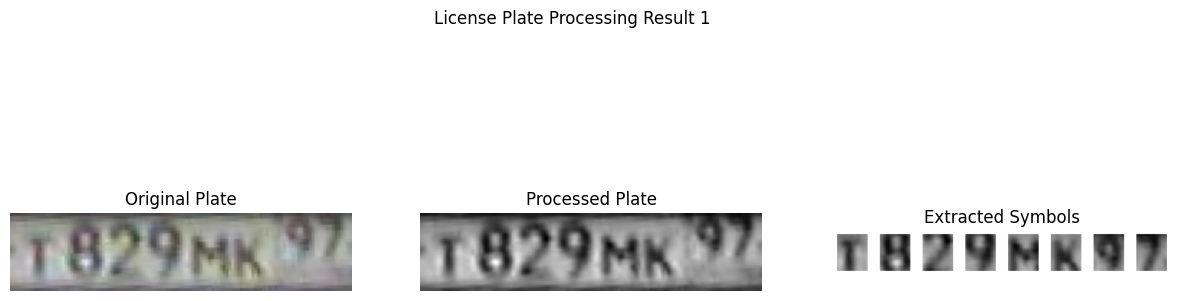

Saved Original Plate to img\plate2_original.jpg
Saved Processed Plate to img\plate2_processed.jpg


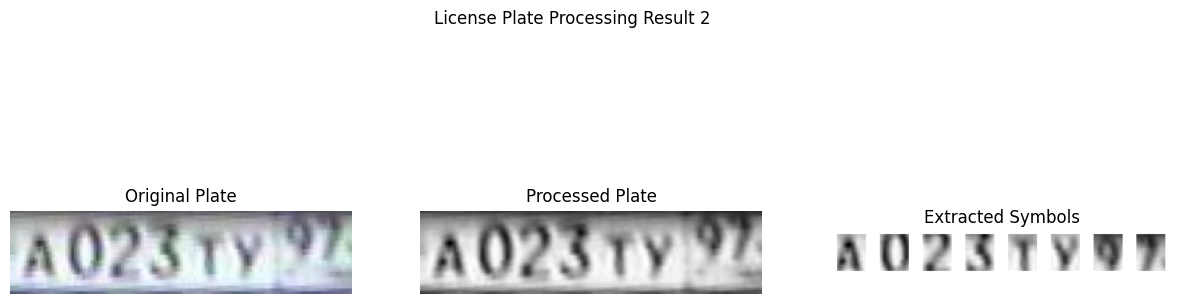

Saved Original Plate to img\plate3_original.jpg
Saved Processed Plate to img\plate3_processed.jpg


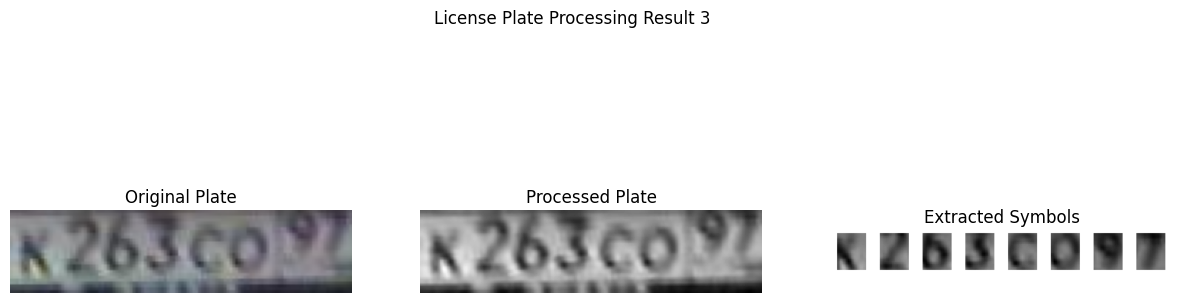

In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps  # Added for padding

# 1. Function to add padding around symbols
def add_padding(img, padding=10):
    """
    Adds padding around the image.

    :param img: Numpy array with the symbol image.
    :param padding: Number of pixels for padding.
    :return: Image with padding.
    """
    # Ensure the image is in uint8 format
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    
    pil_img = Image.fromarray(img)
    padded_img = ImageOps.expand(pil_img, border=padding, fill=255)
    return np.array(padded_img)

# Define mask positions based on GOST standards
# These masks are defined as fractions of the image width and height
# Adjust these values based on the actual license plate layout and resolution

# Mask for plates with 2 region digits (total 8 symbols)
mask_8 = [
    (0.05, 0.25, 0.1, 0.5),  # Символ 1: Буква
    (0.17, 0.25, 0.1, 0.5),  # Символ 2: Цифра
    (0.29, 0.25, 0.1, 0.5),  # Символ 3: Цифра
    (0.41, 0.25, 0.1, 0.5),  # Символ 4: Цифра
    (0.53, 0.25, 0.1, 0.5),  # Символ 5: Буква
    (0.65, 0.25, 0.1, 0.5),  # Символ 6: Буква
    (0.80, 0.05, 0.1, 0.5), # Символ 7: Региональная цифра 1 (выше и меньше)
    (0.90, 0.05, 0.1, 0.5),  # Символ 8: Региональная цифра 2 (выше и меньше)
]


# Mask for plates with 3 region digits (total 9 symbols)
mask_9 = [
    (0.05, 0.2, 0.1, 0.6),  # Symbol 1: Letter
    (0.17, 0.2, 0.1, 0.6),  # Symbol 2: Digit
    (0.29, 0.2, 0.1, 0.6),  # Symbol 3: Digit
    (0.41, 0.2, 0.1, 0.6),  # Symbol 4: Digit
    (0.53, 0.2, 0.1, 0.6),  # Symbol 5: Letter
    (0.65, 0.2, 0.1, 0.6),  # Symbol 6: Letter
    (0.77, 0.2, 0.1, 0.6),  # Symbol 7: Region Digit 1
    (0.89, 0.2, 0.1, 0.6),  # Symbol 8: Region Digit 2
    (1.01, 0.2, 0.1, 0.6)   # Symbol 9: Region Digit 3
]

import cv2
import numpy as np
from PIL import Image, ImageOps

def resize_with_padding(image, size=28, padding=4, bg_color=0):
    """
    Изменяет размер изображения до заданного размера с сохранением соотношения сторон
    и добавлением отступов.
    
    :param image: Градация серого изображения символа (numpy array).
    :param size: Целевой размер (ширина и высота) итогового изображения.
    :param padding: Количество пикселей для отступов.
    :param bg_color: Цвет фона (0 для чёрного, 255 для белого).
    :return: Изображение размером size x size пикселей.
    """
    # Преобразуем numpy array в PIL Image
    pil_img = Image.fromarray(image)
    
    # Определяем текущие размеры
    w, h = pil_img.size
    
    # Рассчитываем масштабирование
    scale = (size - 2 * padding) / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Изменяем размер с сохранением соотношения сторон
    pil_resized = pil_img.resize((new_w, new_h), Image.LANCZOS)
    
    # Создаём новое изображение с фоном
    new_img = Image.new("L", (size, size), color=bg_color)
    
    # Вычисляем позицию для центрирования
    paste_x = (size - new_w) // 2
    paste_y = (size - new_h) // 2
    
    # Вставляем изменённое изображение на фон
    new_img.paste(pil_resized, (paste_x, paste_y))
    
    # Преобразуем обратно в numpy array
    return np.array(new_img)



def extract_symbols(image, masks):
    """
    Extracts symbols from the image based on the provided masks.

    :param image: Grayscale image of the license plate.
    :param masks: List of tuples containing mask definitions as (x_frac, y_frac, w_frac, h_frac).
    :return: List of extracted and resized symbol images.
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        # Ensure the bounding box is within image boundaries
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x_end]
        if symbol.size == 0:
            # If the bounding box is out of image bounds, skip
            continue
        # Add padding
        # Resize to 28x28 pixels
        symbol_resized = resize_with_padding(symbol, size=28, padding=2, bg_color=255)
        symbols.append(symbol_resized)
    return symbols

def is_symbol_present(symbol, threshold=250):
    """
    Determines if a symbol is present based on the mean pixel intensity.

    :param symbol: Grayscale image of the symbol.
    :param threshold: Intensity threshold to consider a symbol as present.
    :return: Boolean indicating presence of a symbol.
    """
    return np.mean(symbol) < threshold  # Darker symbols have lower mean intensity

# Main processing function
def process_plate(plate):
    """
    Processes a single license plate image to extract individual symbols based on masks.

    :param plate: BGR image of the cropped license plate.
    :return: Tuple containing the processed grayscale image and list of extracted symbols.
    """
    # Convert to grayscale
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Resize for consistent processing (adjust fx and fy as needed)
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    # Extract symbols using both mask configurations
    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    # Determine which mask to use based on the presence of the third region digit
    # Check if the 9th symbol (Region Digit 3) is present
    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
    else:
        characters = symbols_8

    return blurred, characters

# Example usage with processed_plates
# Assume processed_plates is a list of BGR images containing cropped license plates
# processed_plates = [cv2.imread('plate1.jpg'), cv2.imread('plate2.jpg'), ...]

output_dir = "img"

for plate_index, plate in enumerate(processed_plates):
    # Ensure the plate image is valid
    if plate is None:
        print(f"Plate {plate_index + 1} could not be loaded.")
        continue

    # Process the plate to extract symbols
    processed_plate, characters = process_plate(plate)

    # Сохранение Original Plate
    original_path = os.path.join(output_dir, f"plate{plate_index + 1}_original.jpg")
    cv2.imwrite(original_path, plate)
    print(f"Saved Original Plate to {original_path}")

    # Сохранение Processed Plate (Grayscale & Blurred)
    processed_path = os.path.join(output_dir, f"plate{plate_index + 1}_processed.jpg")
    cv2.imwrite(processed_path, processed_plate)
    print(f"Saved Processed Plate to {processed_path}")

    # Display the results
    plt.figure(figsize=(15, 5))

    # Original Plate
    plt.subplot(1, 3, 1)
    plt.title("Original Plate")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Processed Plate (Grayscale & Blurred)
    plt.subplot(1, 3, 2)
    plt.title("Processed Plate")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    # Extracted Symbols
    plt.subplot(1, 3, 3)
    plt.title("Extracted Symbols")
    if characters:
        # Arrange symbols in a horizontal grid
        symbols_grid = np.hstack(characters)
        plt.imshow(symbols_grid, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.suptitle(f"License Plate Processing Result {plate_index + 1}")
    plt.show()

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageOps  # Added for padding
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# 1. Function to add padding around symbols
def add_padding(img, padding=10):
    """
    Adds padding around the image.

    :param img: Numpy array with the symbol image.
    :param padding: Number of pixels for padding.
    :return: Image with padding.
    """
    # Ensure the image is in uint8 format
    if img.dtype != np.uint8:
        img = img.astype(np.uint8)
    
    pil_img = Image.fromarray(img)
    padded_img = ImageOps.expand(pil_img, border=padding, fill=255)
    return np.array(padded_img)

# Define mask positions based on GOST standards
# These masks are defined as fractions of the image width and height
# Adjust these values based on the actual license plate layout and resolution

# Mask for plates with 2 region digits (total 8 symbols)
mask_8 = [
    (0.03, 0.05, 0.12, 0.9),  # Символ 1: Буква
    (0.17, 0.05, 0.12, 0.9),  # Символ 2: Цифра
    (0.29, 0.05, 0.12, 0.9),  # Символ 3: Цифра
    (0.41, 0.05, 0.12, 0.9),  # Символ 4: Цифра
    (0.53, 0.05, 0.12, 0.9),  # Символ 5: Буква
    (0.65, 0.05, 0.12, 0.9),  # Символ 6: Буква
    (0.80, 0.05, 0.11, 0.9),  # Символ 7: Региональная цифра 1 (выше и меньше)
    (0.90, 0.05, 0.11, 0.9),  # Символ 8: Региональная цифра 2 (выше и меньше)
]

# Mask for plates with 3 region digits (total 9 symbols)
mask_9 = [
    (0.05, 0.2, 0.1, 0.6),  # Symbol 1: Letter
    (0.17, 0.2, 0.1, 0.6),  # Symbol 2: Digit
    (0.29, 0.2, 0.1, 0.6),  # Symbol 3: Digit
    (0.41, 0.2, 0.1, 0.6),  # Symbol 4: Digit
    (0.53, 0.2, 0.1, 0.6),  # Symbol 5: Letter
    (0.65, 0.2, 0.1, 0.6),  # Symbol 6: Letter
    (0.77, 0.2, 0.1, 0.6),  # Symbol 7: Region Digit 1
    (0.89, 0.2, 0.1, 0.6),  # Symbol 8: Region Digit 2
    (1.01, 0.2, 0.1, 0.6)   # Symbol 9: Region Digit 3
]

def resize_with_padding(image, size=28, padding=4, bg_color=255):
    """
    Изменяет размер изображения до заданного размера с сохранением соотношения сторон
    и добавлением отступов.
    
    :param image: Градация серого изображения символа (numpy array).
    :param size: Целевой размер (ширина и высота) итогового изображения.
    :param padding: Количество пикселей для отступов.
    :param bg_color: Цвет фона (0 для чёрного, 255 для белого).
    :return: Изображение размером size x size пикселей.
    """
    # Преобразуем numpy array в PIL Image
    pil_img = Image.fromarray(image)
    
    # Определяем текущие размеры
    w, h = pil_img.size
    
    # Рассчитываем масштабирование
    scale = (size - 2 * padding) / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    
    # Изменяем размер с сохранением соотношения сторон
    pil_resized = pil_img.resize((new_w, new_h), Image.LANCZOS)
    
    # Создаём новое изображение с фоном
    new_img = Image.new("L", (size, size), color=bg_color)
    
    # Вычисляем позицию для центрирования
    paste_x = (size - new_w) // 2
    paste_y = (size - new_h) // 2
    
    # Вставляем изменённое изображение на фон
    new_img.paste(pil_resized, (paste_x, paste_y))
    
    # Преобразуем обратно в numpy array
    return np.array(new_img)

def extract_symbols(image, masks):
    """
    Extracts symbols from the image based on the provided masks.

    :param image: Grayscale image of the license plate.
    :param masks: List of tuples containing mask definitions as (x_frac, y_frac, w_frac, h_frac).
    :return: List of extracted and resized symbol images.
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        # Ensure the bounding box is within image boundaries
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x_end]
        if symbol.size == 0:
            # If the bounding box is out of image bounds, skip
            continue
        # Add padding
        # Resize to 28x28 pixels
        symbol_resized = resize_with_padding(symbol, size=28, padding=2, bg_color=255)
        symbols.append(symbol_resized)
    return symbols

def is_symbol_present(symbol, threshold=250):
    """
    Determines if a symbol is present based on the mean pixel intensity.

    :param symbol: Grayscale image of the symbol.
    :param threshold: Intensity threshold to consider a symbol as present.
    :return: Boolean indicating presence of a symbol.
    """
    return np.mean(symbol) < threshold  # Darker symbols have lower mean intensity

model = SimpleCNN(len(CLASSES)).to(DEVICE)
SAVE_PATH = "best_model_5.pth"
try:
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
    model.eval()
    print("Модель успешно загружена.")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

# Define transformation for the input symbols
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация, при необходимости измените
])

# Main processing function
def process_plate(plate):
    """
    Processes a single license plate image to extract individual symbols based on masks.

    :param plate: BGR image of the cropped license plate.
    :return: Tuple containing the processed grayscale image and list of extracted symbols.
    """
    # Convert to grayscale
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    # Resize for consistent processing (adjust fx and fy as needed)
    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    # Extract symbols using both mask configurations
    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    # Determine which mask to use based on the presence of the third region digit
    # Check if the 9th symbol (Region Digit 3) is present
    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
    else:
        characters = symbols_8

    return blurred, characters

for plate_index, plate in enumerate(processed_plates):
    # Ensure the plate image is valid
    if plate is None:
        print(f"Plate {plate_index + 1} could not be loaded.")
        continue

    # Process the plate to extract symbols
    processed_plate, characters = process_plate(plate)

    # Predict symbols using the model
    predictions = []
    for symbol_img in characters:
        # Предобработка изображения
        input_tensor = transform(symbol_img).unsqueeze(0).to(DEVICE)  # [1, 1, 28, 28]
        
        with torch.no_grad():
            outputs = model(input_tensor)
            _, predicted = torch.max(outputs, 1)
            predicted_label = CLASSES[predicted.item()]
            predictions.append(predicted_label)
    
    # Display the results
    plt.figure(figsize=(15, 5))

    # Original Plate
    plt.subplot(1, 4, 1)
    plt.title("Original Plate")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    # Processed Plate (Grayscale & Blurred)
    plt.subplot(1, 4, 2)
    plt.title("Processed Plate")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    # Extracted Symbols
    plt.subplot(1, 4, 3)
    plt.title("Extracted Symbols")
    if characters:
        # Arrange symbols in a horizontal grid
        symbols_grid = np.hstack(characters)
        plt.imshow(symbols_grid, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    # Recognized Symbols with Predictions
    plt.subplot(1, 4, 4)
    plt.title("Recognized Symbols")
    if characters and predictions:
        # Создадим холст для отображения символов с метками
        symbol_images = [resize_with_padding(sym, size=28, padding=0, bg_color=255) for sym in characters]
        num_symbols = len(symbol_images)
        # Создадим пустой холст для размещения символов и меток
        canvas = np.ones((28 + 10, 28 * num_symbols + 10), dtype=np.uint8) * 255  # 10 пикселей отступа
        for i, (sym, pred) in enumerate(zip(symbol_images, predictions)):
            canvas[0:28, i*28 + 5:(i+1)*28 + 5] = sym  # Расположим символы с отступом
            # Добавим текст метки под символом
            plt.text(i*28 + 14, 28 + 5, pred, ha='center', va='center', fontsize=8, color='blue')
        plt.imshow(canvas, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.suptitle(f"License Plate Processing and Recognition Result {plate_index + 1}")
    plt.tight_layout()
    plt.show()


NameError: name 'SimpleCNN' is not defined

Модель успешно загружена.
Первая - T, Итоговая - T
Первая - 8, Итоговая - 8
Первая - 2, Итоговая - 2
Первая - 9, Итоговая - 9
Первая - M, Итоговая - M
Первая - K, Итоговая - K
Первая - 9, Итоговая - 9
Первая - 7, Итоговая - 7


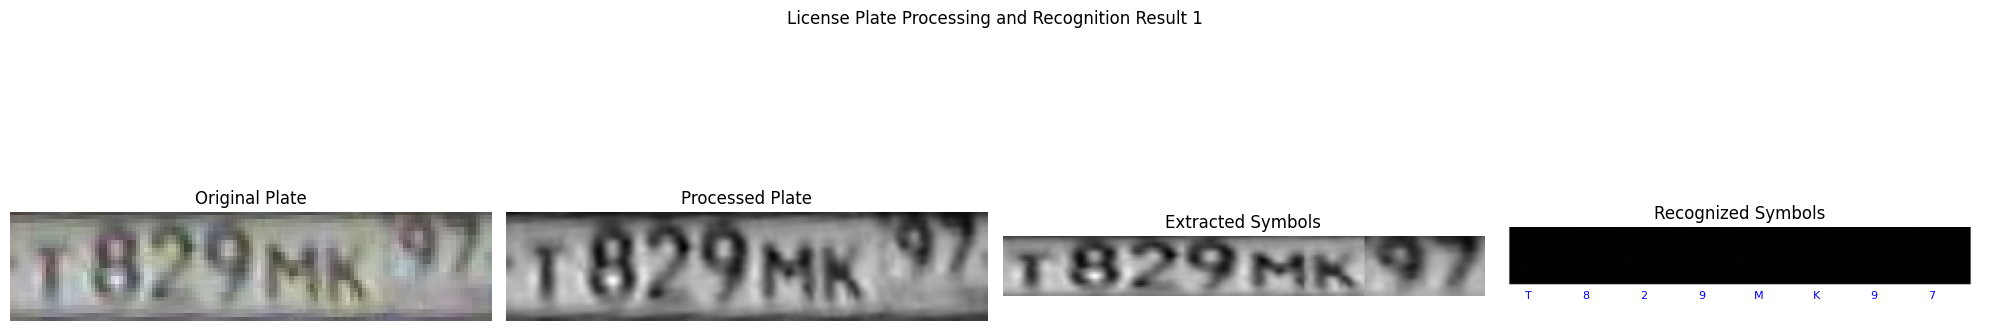

Первая - A, Итоговая - A
Первая - 0, Итоговая - 0
Первая - 2, Итоговая - 2
Первая - 3, Итоговая - 3
Первая - T, Итоговая - T
Первая - Y, Итоговая - Y
Первая - 9, Итоговая - 9
Первая - 7, Итоговая - 7


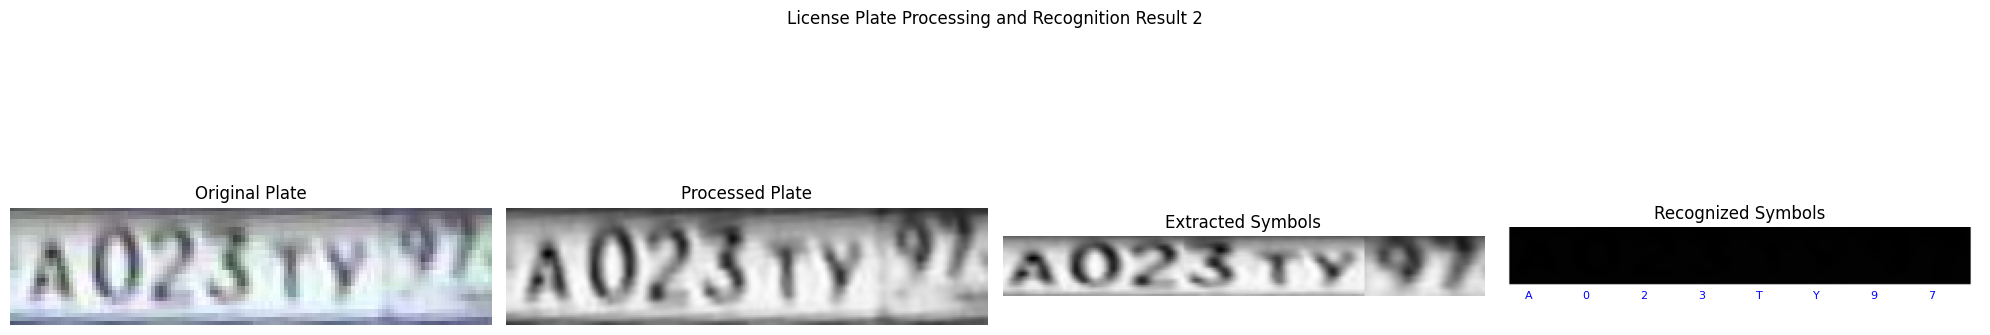

Первая - K, Итоговая - K
Первая - 2, Итоговая - 2
Первая - 6, Итоговая - 6
Первая - 3, Итоговая - 3
Первая - C, Итоговая - C
Первая - O, Итоговая - O
Первая - 9, Итоговая - 9
Первая - 7, Итоговая - 7


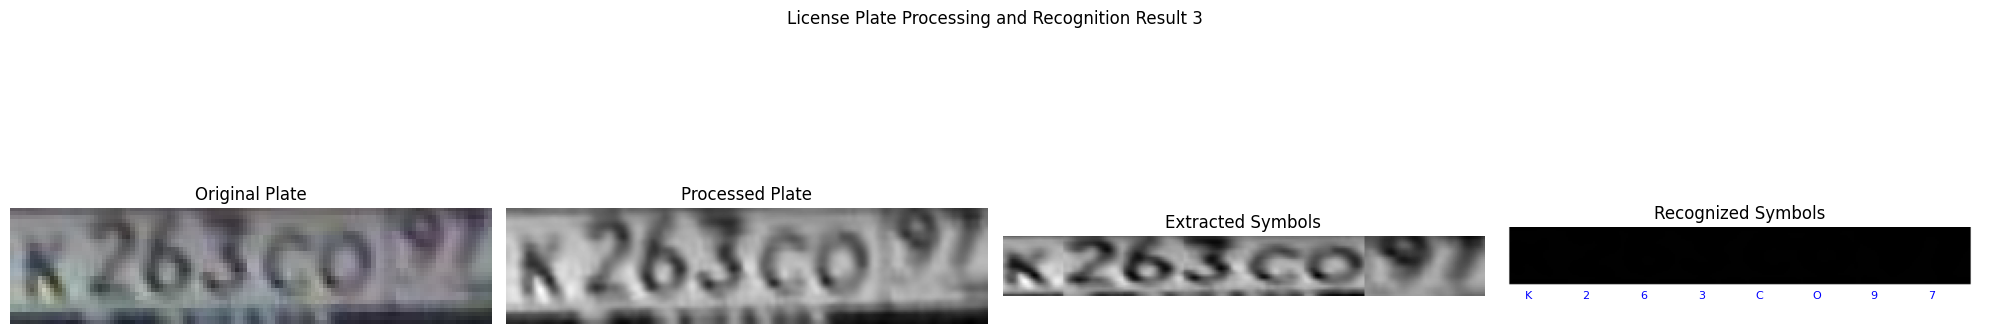

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize((0.25,), (0.25,))  
])

def extract_symbols(image, masks):
    """
    Извлекает символы из изображения на основе предоставленных масок.

    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями масок как (x_frac, y_frac, w_frac, h_frac).
    :return: Список извлечённых символов (numpy arrays).
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x_end]
        if symbol.size == 0:
            continue

        symbols.append(symbol)
    return symbols

def is_symbol_present(symbol, threshold=250):
    """
    Определяет, присутствует ли символ на основе средней интенсивности пикселей.

    :param symbol: Градация серого изображения символа.
    :param threshold: Порог интенсивности для определения наличия символа.
    :return: Булево значение, указывающее на наличие символа.
    """
    return np.mean(symbol) < threshold  

class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.SiLU(),
            nn.BatchNorm2d(128),
            nn.AdaptiveAvgPool2d((1, 1))  # Глобальный Average Pooling
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128, 256),
            nn.SiLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)  # Разворачиваем перед линейным слоем
        x = self.fc_layers(x)
        return x
model = ImprovedCNN(len(CLASSES)).to(DEVICE)
SAVE_PATH = "best_model_9.pth"
try:
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
    model.eval()
    print("Модель успешно загружена.")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

def process_plate(plate):
    """
    Обрабатывает одно изображение номерного знака для извлечения отдельных символов на основе масок.

    :param plate: BGR изображение обрезанного номерного знака.
    :return: Кортеж, содержащий обработанное градационное изображение и список извлечённых символов.
    """
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
        expected_types = expected_types_9
    else:
        characters = symbols_8
        expected_types = expected_types_8

    return blurred, characters, expected_types

    

expected_types_8 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit']
expected_types_9 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit', 'digit']

digits = set(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
letters = set([c for c in CLASSES if c.isalpha()])

mask_8 = [
    (0.03, 0.05, 0.12, 0.9),  # Символ 1: Буква
    (0.16, 0.05, 0.12, 0.9),  # Символ 2: Цифра
    (0.28, 0.05, 0.12, 0.9),  # Символ 3: Цифра
    (0.40, 0.05, 0.12, 0.9),  # Символ 4: Цифра
    (0.52, 0.05, 0.12, 0.9),  # Символ 5: Буква
    (0.64, 0.05, 0.12, 0.9),  # Символ 6: Буква
    (0.79, 0.07, 0.10, 0.60),  # Символ 7: Региональная цифра 1
    (0.89, 0.07, 0.10, 0.60),  # Символ 8: Региональная цифра 2 
]

mask_9 = [
    (0.05, 0.2, 0.1, 0.6),  # Symbol 1: Letter
    (0.17, 0.2, 0.1, 0.6),  # Symbol 2: Digit
    (0.29, 0.2, 0.1, 0.6),  # Symbol 3: Digit
    (0.41, 0.2, 0.1, 0.6),  # Symbol 4: Digit
    (0.53, 0.2, 0.1, 0.6),  # Symbol 5: Letter
    (0.65, 0.2, 0.1, 0.6),  # Symbol 6: Letter
    (0.77, 0.2, 0.1, 0.6),  # Symbol 7: Region Digit 1
    (0.89, 0.2, 0.1, 0.6),  # Symbol 8: Region Digit 2
    (1.01, 0.2, 0.1, 0.6)   # Symbol 9: Region Digit 3
]
alls = []
alls_t = []

for plate_index, plate in enumerate(processed_plates):

    if plate is None:
        print(f"Plate {plate_index + 1} could not be loaded.")
        continue

    processed_plate, characters, expected_types = process_plate(plate)

    predictions = []
    transformed_symbols = []
    input_tensors = []
    for idx, (symbol_img, expected_type) in enumerate(zip(characters, expected_types)):

        input_tensor = transform(symbol_img).unsqueeze(0).to(DEVICE)
        input_tensors.append(input_tensor)

        transformed_image = transform(symbol_img).squeeze().cpu().numpy()
        transformed_symbols.append(transformed_image)

        with torch.no_grad():
            outputs = model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            probs, indices = torch.sort(probabilities, descending=True)

            predicted_labels = [CLASSES[i] for i in indices[0]]
            if expected_type == 'letter':

                if predicted_labels[0] == '0':
                    predicted_labels[0] = 'O'
                elif predicted_labels[0] == '8':
                    predicted_labels[0] = 'B'

                for label in predicted_labels:
                    if label in letters:
                        predicted_label = label
                        break
                else:
                    predicted_label = predicted_labels[0]

            elif expected_type == 'digit':

                if predicted_labels[0] == 'O':
                    predicted_labels[0] = '0'
                elif predicted_labels[0] == 'B':
                    predicted_labels[0] = '8'

                for label in predicted_labels:
                    if label in digits:
                        predicted_label = label
                        break
                else:
                    predicted_label = predicted_labels[0]
                

            else:
                predicted_label = predicted_labels[0]
            print(f'Первая - {predicted_labels[0]}, Итоговая - {predicted_label}')
            predictions.append(predicted_label)
    alls.append(transformed_symbols)
    alls_t.append(input_tensors)

    plt.figure(figsize=(20, 5))


    plt.subplot(1, 4, 1)
    plt.title("Original Plate")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Processed Plate")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Extracted Symbols")
    if transformed_symbols:
        symbols_grid = np.hstack(transformed_symbols)
        plt.imshow(symbols_grid, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Recognized Symbols")
    if transformed_symbols and predictions:

        num_symbols = len(transformed_symbols)
        canvas = np.ones((28 + 10, 28 * num_symbols + 10), dtype=np.uint8) * 255 
        for i, (sym, pred) in enumerate(zip(transformed_symbols, predictions)):
            canvas[0:28, i*28 + 5:(i+1)*28 + 5] = sym 
            plt.text(i*28 + 14, 28 + 5, pred, ha='center', va='center', fontsize=8, color='blue')
        plt.imshow(canvas, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')
    

    plt.suptitle(f"License Plate Processing and Recognition Result {plate_index + 1}")
    plt.tight_layout()
    plt.show()


In [51]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

# Предполагается, что CLASSES и DEVICE уже определены
# Например:
# CLASSES = ['A', 'B', 'C', ..., '0', '1', ..., '9']
# DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Разделение классов на буквы и цифры
letters = [cls for cls in CLASSES if cls.isalpha()]
digits = [cls for cls in CLASSES if cls.isdigit()]

# Создание словарей для быстрого доступа к индексам
letter_indices = {cls: idx for idx, cls in enumerate(CLASSES) if cls.isalpha()}
digit_indices = {cls: idx for idx, cls in enumerate(CLASSES) if cls.isdigit()}

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize((0.25,), (0.25,))  
])

def extract_symbols(image, masks):
    """
    Извлекает символы из изображения на основе предоставленных масок.

    :param image: Градация серого изображения номерного знака.
    :param masks: Список кортежей с определениями масок как (x_frac, y_frac, w_frac, h_frac).
    :return: Список извлечённых символов (numpy arrays).
    """
    img_h, img_w = image.shape
    symbols = []
    for bbox in masks:
        x_frac, y_frac, w_frac, h_frac = bbox
        x = int(x_frac * img_w)
        y = int(y_frac * img_h)
        w = int(w_frac * img_w)
        h = int(h_frac * img_h)
        
        x_end = min(x + w, img_w)
        y_end = min(y + h, img_h)
        
        symbol = image[y:y_end, x:x_end]
        if symbol.size == 0:
            continue

        symbols.append(symbol)
    return symbols

def is_symbol_present(symbol, threshold=250):
    """
    Определяет, присутствует ли символ на основе средней интенсивности пикселей.

    :param symbol: Градация серого изображения символа.
    :param threshold: Порог интенсивности для определения наличия символа.
    :return: Булево значение, указывающее на наличие символа.
    """
    return np.mean(symbol) < threshold  

# Определение модели (предполагается, что SimpleCNN определен)
model = SimpleCNN(len(CLASSES)).to(DEVICE)
SAVE_PATH = "best_model_8.pth"
try:
    model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
    model.eval()
    print("Модель успешно загружена.")
except Exception as e:
    print(f"Ошибка при загрузке модели: {e}")

def process_plate(plate):
    """
    Обрабатывает одно изображение номерного знака для извлечения отдельных символов на основе масок.

    :param plate: BGR изображение обрезанного номерного знака.
    :return: Кортеж, содержащий обработанное градационное изображение и список извлечённых символов.
    """
    gray_plate = cv2.cvtColor(plate, cv2.COLOR_BGR2GRAY)

    resized_plate = cv2.resize(gray_plate, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    img_h, img_w = resized_plate.shape

    blurred = cv2.GaussianBlur(resized_plate, (3, 3), 0)

    symbols_8 = extract_symbols(blurred, mask_8)
    symbols_9 = extract_symbols(blurred, mask_9)

    if len(symbols_9) == 9 and is_symbol_present(symbols_9[-1]):
        characters = symbols_9
    else:
        characters = symbols_8

    return blurred, characters

mask_8 = [
    (0.03, 0.05, 0.12, 0.9),  # Символ 1: Буква
    (0.16, 0.05, 0.12, 0.9),  # Символ 2: Цифра
    (0.28, 0.05, 0.12, 0.9),  # Символ 3: Цифра
    (0.40, 0.05, 0.12, 0.9),  # Символ 4: Цифра
    (0.52, 0.05, 0.12, 0.9),  # Символ 5: Буква
    (0.64, 0.05, 0.12, 0.9),  # Символ 6: Буква
    (0.80, 0.05, 0.11, 0.6),  # Символ 7: Региональная цифра 1
    (0.90, 0.05, 0.11, 0.6),  # Символ 8: Региональная цифра 2 
]

mask_9 = [
    (0.05, 0.2, 0.1, 0.6),  # Symbol 1: Letter
    (0.17, 0.2, 0.1, 0.6),  # Symbol 2: Digit
    (0.29, 0.2, 0.1, 0.6),  # Symbol 3: Digit
    (0.41, 0.2, 0.1, 0.6),  # Symbol 4: Digit
    (0.53, 0.2, 0.1, 0.6),  # Symbol 5: Letter
    (0.65, 0.2, 0.1, 0.6),  # Symbol 6: Letter
    (0.77, 0.2, 0.1, 0.6),  # Symbol 7: Region Digit 1
    (0.89, 0.2, 0.1, 0.6),  # Symbol 8: Region Digit 2
    (1.01, 0.2, 0.1, 0.6)   # Symbol 9: Region Digit 3
]

# Определение ожидаемых типов символов для mask_8 и mask_9
expected_types_8 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit']
expected_types_9 = ['letter', 'digit', 'digit', 'digit', 'letter', 'letter', 'digit', 'digit', 'digit']

alls = []
alls_t = []

for plate_index, plate in enumerate(processed_plates):

    if plate is None:
        print(f"Plate {plate_index + 1} could not be loaded.")
        continue

    processed_plate, characters = process_plate(plate)

    # Выбор соответствующего списка ожидаемых типов
    if characters == symbols_9:
        expected_types = expected_types_9
    else:
        expected_types = expected_types_8

    predictions = []
    transformed_symbols = [] 
    input_tensors = []
    for idx, symbol_img in enumerate(characters):
        input_tensor = transform(symbol_img).unsqueeze(0).to(DEVICE) 
        input_tensors.append(input_tensor)

        transformed_image = transform(symbol_img).squeeze().cpu().numpy()  
        transformed_symbols.append(transformed_image)

        with torch.no_grad():
            outputs = model(input_tensor)  # Предполагается, что модель возвращает сырые логиты

            # Применяем softmax для получения вероятностей
            probabilities = F.softmax(outputs, dim=1).squeeze()

            # Определение ожидаемого типа символа
            expected_type = expected_types[idx]

            if expected_type == 'letter':
                # Получение индексов классов-букв
                class_indices = [CLASSES.index(cls) for cls in letters]
            elif expected_type == 'digit':
                # Получение индексов классов-цифр
                class_indices = [CLASSES.index(cls) for cls in digits]
            else:
                # Если тип не определен, использовать все классы
                class_indices = list(range(len(CLASSES)))

            # Извлечение вероятностей для соответствующих классов
            if len(class_indices) == 0:
                print(f"Неизвестный тип символа: {expected_type}. Используются все классы.")
                class_indices = list(range(len(CLASSES)))

            filtered_probs = probabilities[class_indices]
            if filtered_probs.numel() == 0:
                print(f"Нет классов для типа: {expected_type}.")
                predicted_label = "Unknown"
            else:
                # Получение индекса максимальной вероятности среди отфильтрованных
                max_prob, max_idx = torch.max(filtered_probs, dim=0)
                predicted_label = CLASSES[class_indices[max_idx.item()]]

            predictions.append(predicted_label)

    alls.append(transformed_symbols)
    alls_t.append(input_tensors)

    plt.figure(figsize=(20, 5))

    plt.subplot(1, 4, 1)
    plt.title("Original Plate")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.title("Processed Plate")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.title("Extracted Symbols")
    if transformed_symbols:
        symbols_grid = np.hstack(transformed_symbols)
        plt.imshow(symbols_grid, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.title("Recognized Symbols")
    if transformed_symbols and predictions:

        num_symbols = len(transformed_symbols)
        canvas = np.ones((28 + 20, 28 * num_symbols + 10), dtype=np.uint8) * 255 
        for i, (sym, pred) in enumerate(zip(transformed_symbols, predictions)):
            canvas[0:28, i*28 + 5:(i+1)*28 + 5] = sym 
            plt.text(i*28 + 14, 28 + 10, pred, ha='center', va='center', fontsize=12, color='blue')
        plt.imshow(canvas, cmap='gray')
    else:
        plt.text(0.5, 0.5, 'No Symbols Detected', ha='center', va='center', fontsize=12)
    plt.axis('off')

    plt.suptitle(f"License Plate Processing and Recognition Result {plate_index + 1}")
    plt.tight_layout()
    plt.show()


C:\Users\leonk\AppData\Local\Temp\ipykernel_17656\332507320.py:72: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(SAVE_PATH, map_location=DEV

Модель успешно загружена.


NameError: name 'symbols_9' is not defined

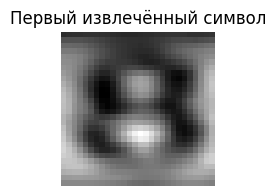

In [109]:
import numpy as np
import matplotlib.pyplot as plt

def display_symbol(symbol_array, is_grayscale=True, title="Символ"):
    """
    Отображает символ из numpy массива.

    :param symbol_array: Numpy массив, представляющий изображение символа.
    :param is_grayscale: Булево значение, указывающее, является ли изображение чёрно-белым.
    :param title: Заголовок для графика.
    """
    plt.figure(figsize=(2, 2))  # Устанавливаем размер фигуры

    if is_grayscale:
        # Для чёрно-белых изображений используем cmap='gray'
        plt.imshow(symbol_array, cmap='gray', interpolation='nearest')
    else:
        # Для цветных изображений предполагаем, что массив имеет форму (H, W, 3)
        plt.imshow(symbol_array, interpolation='nearest')

    plt.title(title)
    plt.axis('off')  # Отключаем оси
    plt.show()

# Пример использования

# Предполагается, что transformed_symbols уже определён и содержит хотя бы один символ
# Например:
# transformed_symbols = [numpy_array1, numpy_array2, ...]

# Проверяем, что transformed_symbols не пуст
try:
    # Извлекаем первый символ
    first_symbol = alls[0][1]
    
    # Определяем, является ли изображение чёрно-белым или цветным
    if len(first_symbol.shape) == 2:
        is_grayscale = True
    elif len(first_symbol.shape) == 3 and first_symbol.shape[2] == 3:
        is_grayscale = False
    else:
        raise ValueError("Неподдерживаемый формат изображения.")
    
    # Отображаем первый символ
    display_symbol(first_symbol, is_grayscale=is_grayscale, title="Первый извлечённый символ")
    
except IndexError:
    print("Список transformed_symbols пуст. Убедитесь, что символы были успешно извлечены.")
except Exception as e:
    print(f"Произошла ошибка при отображении символа: {e}")


In [32]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import torch

# Инициализация модели
model_letters = SimpleCNN(len(LETTERS)).to(DEVICE)  # Инициализация модели для букв
model_letters.load_state_dict(torch.load("best_model_letters.pth", map_location=DEVICE))  # Загрузка весов
model_letters.eval()

model_digits = SimpleCNN(len(DIGITS)).to(DEVICE)  # Инициализация модели для цифр
model_digits.load_state_dict(torch.load("best_model_digits.pth", map_location=DEVICE))  # Загрузка весов
model_digits.eval()

def process_and_recognize_plate_with_processing(plate, model_digits, model_letters, transform, device="cpu", padding=5):
    """
    Обрабатывает пластину, распознаёт символы с дополнительной обработкой и возвращает текстовую строку.
    
    :param plate: Изображение пластины.
    :param model_digits: Модель для распознавания цифр.
    :param model_letters: Модель для распознавания букв.
    :param transform: Преобразование изображения для модели.
    :param device: Устройство для вычислений ("cpu" или "cuda").
    :param padding: Отступ для символов.
    :return: Обработанная пластина, список символов, распознанная строка.
    """
    # Обработка пластины
    processed_plate, characters = process_plate(plate)
    
    # Распознавание символов
    recognized_text = ""
    processed_characters = []
    for i, char in enumerate(characters):
        # Выбор модели для символа
        if i in {0, 4, 5}:  # 1-й, 5-й и 6-й символы (нумерация с 0)
            model = model_letters
        else:
            model = model_digits
        
        # Распознавание символа
        recognized_char, processed_char = predict_character_with_processing(
            model, char, transform, device, padding=padding
        )
        recognized_text += recognized_char
        processed_characters.append(processed_char)
    
    return processed_plate, processed_characters, recognized_text

# Пример использования с массивом processed_plates
all_recognized_texts = []
for plate_index, plate in enumerate(processed_plates):
    # Обработка пластины и распознавание символов
    processed_plate, processed_characters, recognized_text = process_and_recognize_plate_with_processing(
        plate, model_digits, model_letters, transform, device=DEVICE, padding=5
    )

    # Сохранение распознанного текста
    all_recognized_texts.append(recognized_text)

    # Визуализация результатов
    plt.figure(figsize=(15, 5))

    # Исходная пластина
    plt.subplot(1, 3, 1)
    plt.title("Исходная картинка")
    plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))  # Преобразуем для корректного отображения
    plt.axis('off')

    # Обработанная пластина
    plt.subplot(1, 3, 2)
    plt.title("Обработанная картинка")
    plt.imshow(processed_plate, cmap='gray')
    plt.axis('off')

    # Выделенные символы и итоговый текст
    plt.subplot(1, 3, 3)
    plt.title("Выделенные символы")
    if processed_characters:
        symbols_grid = np.hstack(processed_characters)
        plt.imshow(symbols_grid, cmap='gray')
        plt.xlabel(f"Распознанный текст: {recognized_text}")
    else:
        plt.text(0.5, 0.5, 'Нет символов', ha='center', va='center')
    plt.axis('off')

    plt.suptitle(f"Результат обработки пластинки {plate_index + 1} - {recognized_text}")
    plt.show()


NameError: name 'LETTERS' is not defined

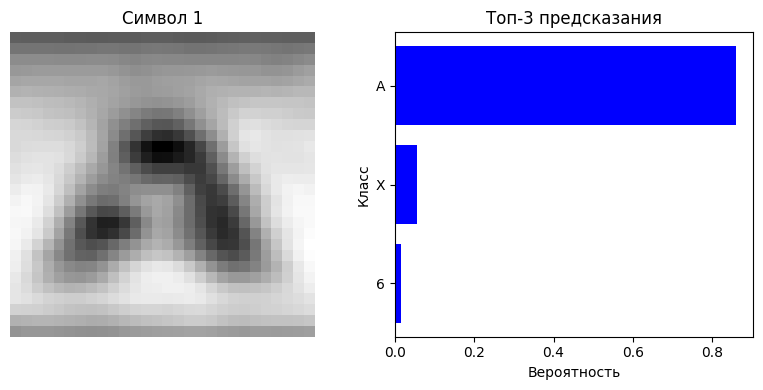

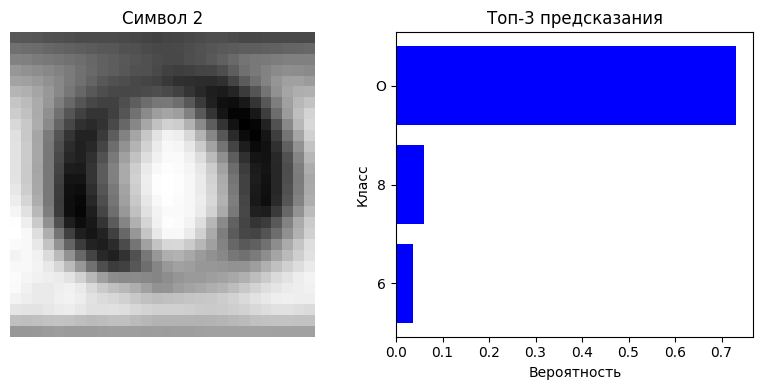

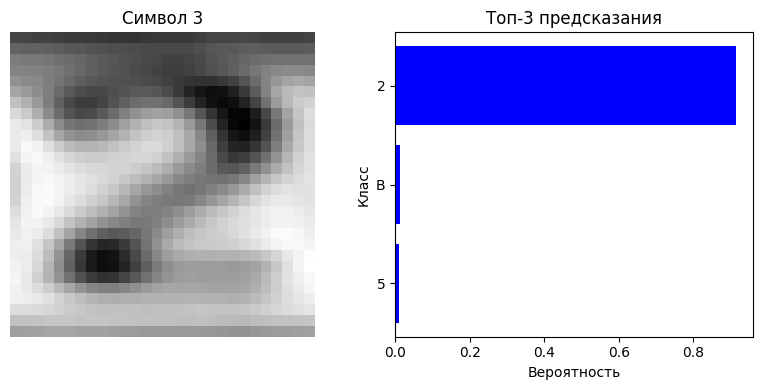

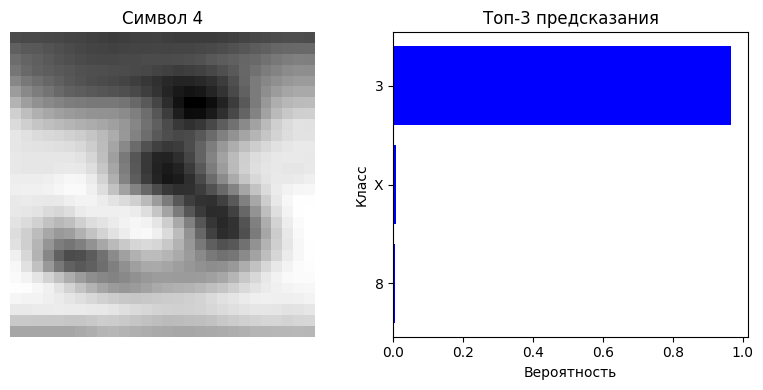

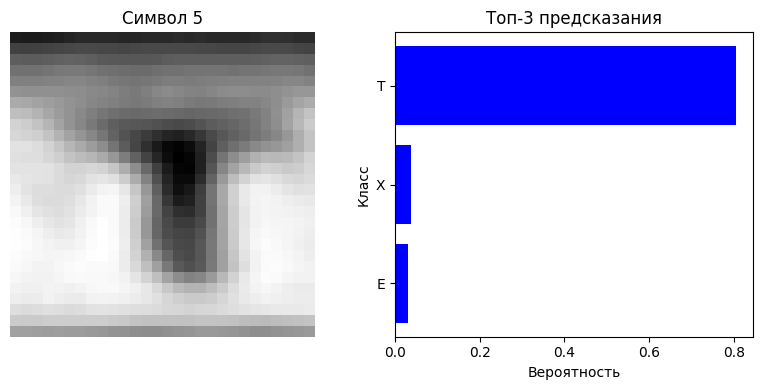

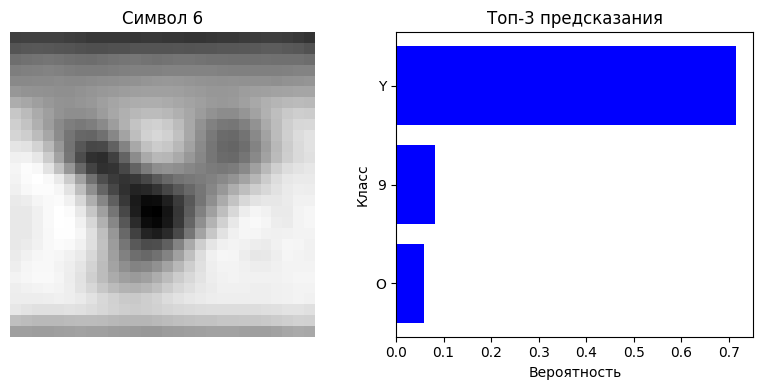

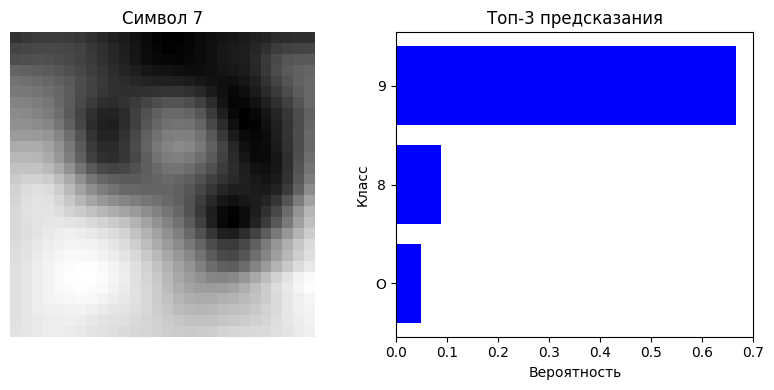

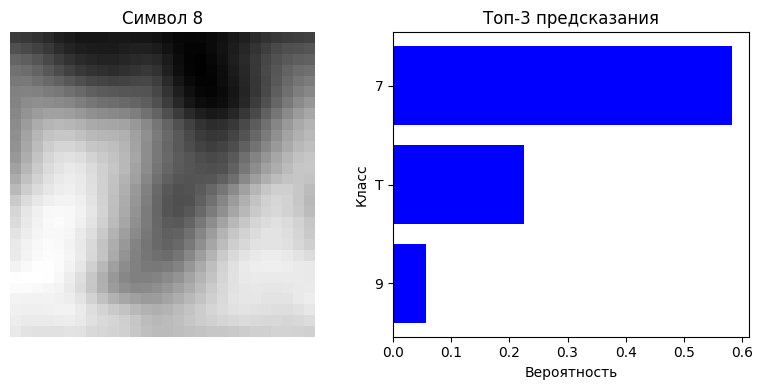

In [10]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

# Классы символов
#CLASSES = "DABEKMHOPCTYX0123456789"
#NUM_CLASSES = len(CLASSES)

# Загрузка модели и весов
#DEVICE = "cpu"  # Или "cuda", если доступен GPU
#model = SimpleCNN(NUM_CLASSES).to(DEVICE)
#model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))  # Загрузка весов
#model.eval()

# Преобразование для входных данных
transform = transforms.Compose([
     # Изменение яркости (0.5 - уменьшение, >1 - увеличение)
    transforms.ToTensor(),
    #transforms.ColorJitter(brightness=0.5),
    #transforms.Normalize((0.5,), (0.5,))  # Нормализация значений пикселей
])

# Функция для получения топ-3 предсказаний
def get_top_predictions(output, top_k=3):
    probabilities = torch.softmax(output, dim=1).squeeze()  # Преобразование в вероятности
    top_probs, top_indices = torch.topk(probabilities, top_k)
    return top_probs.tolist(), [CLASSES[idx] for idx in top_indices.tolist()]

# Функция распознавания символов с выводом графиков
def recognize_and_plot_characters(characters, model, device="cpu"):
    """
    Распознает символы из списка изображений characters и строит графики топ-3 предсказаний.

    :param characters: Список символов (массивы numpy 28x28).
    :param model: Загруженная модель для распознавания.
    :param device: Устройство для вычислений ("cpu" или "cuda").
    """
    for i, char in enumerate(characters):
        # Преобразование символа в тензор
        char_tensor = transform(char).unsqueeze(0).to(device)  # Добавляем batch размерности
        
        # Прогон через модель
        with torch.no_grad():
            output = model(char_tensor)
            top_probs, top_classes = get_top_predictions(output)

        # Вывод символа и графика топ-3 предсказаний
        plt.figure(figsize=(8, 4))

        # Символ
        plt.subplot(1, 2, 1)
        plt.imshow(char, cmap='gray')
        plt.axis('off')
        plt.title(f"Символ {i + 1}")

        # Топ-3 предсказания
        plt.subplot(1, 2, 2)
        plt.barh(top_classes, top_probs, color='blue')
        plt.xlabel("Вероятность")
        plt.ylabel("Класс")
        plt.title("Топ-3 предсказания")
        plt.gca().invert_yaxis()  # Инвертируем ось, чтобы лучший класс был сверху

        plt.tight_layout()
        plt.show()

# Использование функции
if 'characters' in locals() and len(transformed_symbols) > 0:
    recognize_and_plot_characters(alls[1], model, device=DEVICE)
else:
    print("Список characters пуст.")


Топ-10 предсказаний:
1: B (вероятность: 0.3549)
2: P (вероятность: 0.2256)
3: 7 (вероятность: 0.0604)
4: E (вероятность: 0.0508)
5: 2 (вероятность: 0.0501)
6: A (вероятность: 0.0425)
7: M (вероятность: 0.0313)
8: 8 (вероятность: 0.0289)
9: 3 (вероятность: 0.0235)
10: O (вероятность: 0.0192)


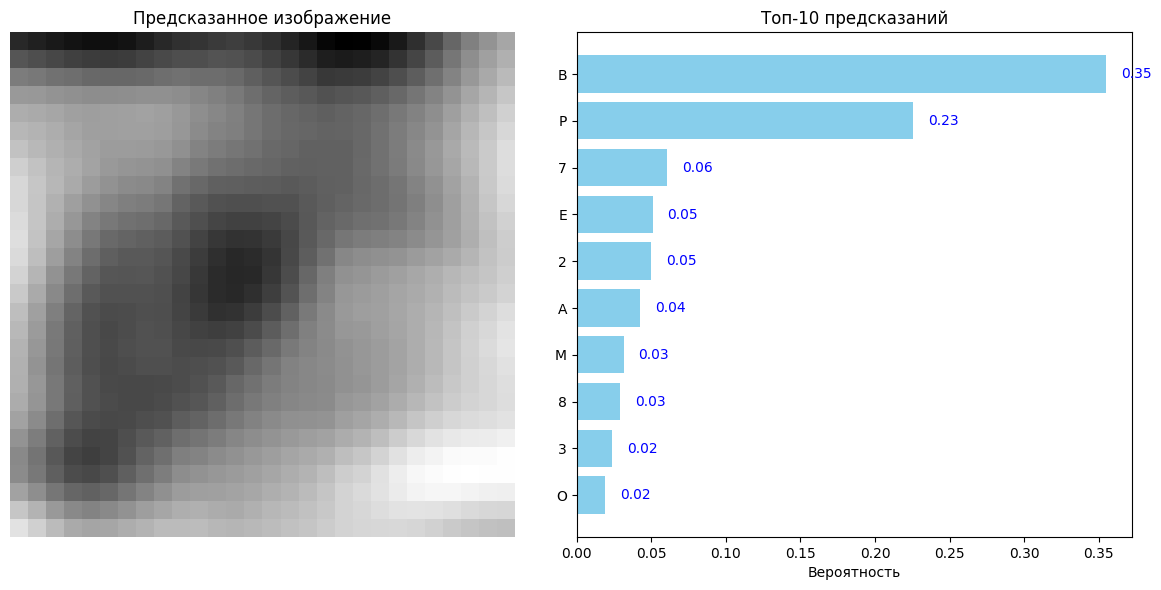

In [90]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Предполагается, что CLASSES и DEVICE определены ранее
# Например:
# CLASSES = ['A', 'B', 'C', ..., 'Z', '0', '1', ..., '9']
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Путь к изображению
image_path = "img/7-viva4.jpg"
transform = transforms.Compose([
        transforms.Resize((28, 28)),  # Изменяем размер до 28x28
        transforms.ToTensor(),       # Преобразуем в тензор
        transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация: среднее 0.5, стандартное отклонение 0.5
    ])

transform1 = transforms.Compose([
        transforms.ToTensor(),       # Преобразуем в тензор
        #transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация: среднее 0.5, стандартное отклонение 0.5
    ])
# Предобработка изображения для чёрно-белого изображения 28x28
def preprocess_image(image_path):
    # Загрузка изображения
    image = Image.open(image_path).convert('L')  # Преобразование в чёрно-белое
    # Применение трансформаций
    image_tensor = transform(image)
    
    # Добавление batch dimension
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

# Загрузка и обработка изображения
image_tensor = preprocess_image(image_path).to(DEVICE)
char_tensor = transform1(transformed_symbols[3]).unsqueeze(0).to(DEVICE)

# Загрузка модели (предполагается, что модель уже определена)
# model = SimpleCNN(len(CLASSES)).to(DEVICE)
# Загрузка весов модели
# model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
# model.eval()

# Убедитесь, что модель находится в режиме оценки
model.eval()

# Добавление вывода изображения и графика топ-10 предсказаний
def plot_image_and_predictions(image_tensor, classes):
    """
    Отображает изображение и график топ-10 предсказаний модели.
    
    :param image_tensor: Тензор изображения после предобработки.
    :param top_probs: Топ-10 вероятностей предсказаний.
    :param top_indices: Индексы топ-10 классов.
    :param classes: Список названий классов.
    """
    # Обратная нормализация для отображения изображения
    # Если нормализация была (mean=0.5, std=0.5), то обратная:
    # x = x * std + mean

    # Предсказание
    with torch.no_grad():
        output = model(image_tensor)  # Получение выхода модели
        probabilities = torch.softmax(output, dim=1)  # Преобразование выходов в вероятности
        top10_probabilities, top10_indices = torch.topk(probabilities, 10, dim=1)  # Получение топ-10
        
        top_probs = top10_probabilities.squeeze(0)  # Удаление batch-дименшена
        top_indices = top10_indices.squeeze(0)  # Удаление batch-дименшена

    print("Топ-10 предсказаний:")
    for i in range(10):
        predicted_class = top_indices[i].item()
        probability = top_probs[i].item()
        print(f"{i + 1}: {CLASSES[predicted_class]} (вероятность: {probability:.4f})")
        
    unnormalize = transforms.Normalize(
        mean=[-0.5 / 0.5],
        std=[1 / 0.5]
    )
    image_tensor_unnorm = unnormalize(image_tensor.squeeze(0)).cpu().numpy()
    
    # Переводим тензор в формат [H, W]
    image_np = image_tensor_unnorm.squeeze(0)
    image_np = np.clip(image_np, 0, 1)  # Ограничиваем значения для корректного отображения
    
    # Получение топ-10 классов и их вероятностей
    top_classes = [classes[idx] for idx in top_indices]
    top_probs = top_probs.cpu().numpy()
    
    # Создание фигуры с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Отображение изображения
    ax1.imshow(image_np, cmap='gray')
    ax1.set_title("Предсказанное изображение")
    ax1.axis('off')
    
    # Отображение графика топ-10 предсказаний
    ax2.barh(range(10), top_probs, color='skyblue')  # Инвертируем для отображения сверху вниз
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(top_classes)
    ax2.invert_yaxis()  # Самый высокий показатель сверху
    ax2.set_xlabel('Вероятность')
    ax2.set_title('Топ-10 предсказаний')
    
    # Добавление вероятностей на график
    for i, v in enumerate(top_probs):
        ax2.text(v + 0.01, i, f"{v:.2f}", color='blue', va='center')
    
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения
plot_image_and_predictions(image_tensor, CLASSES)


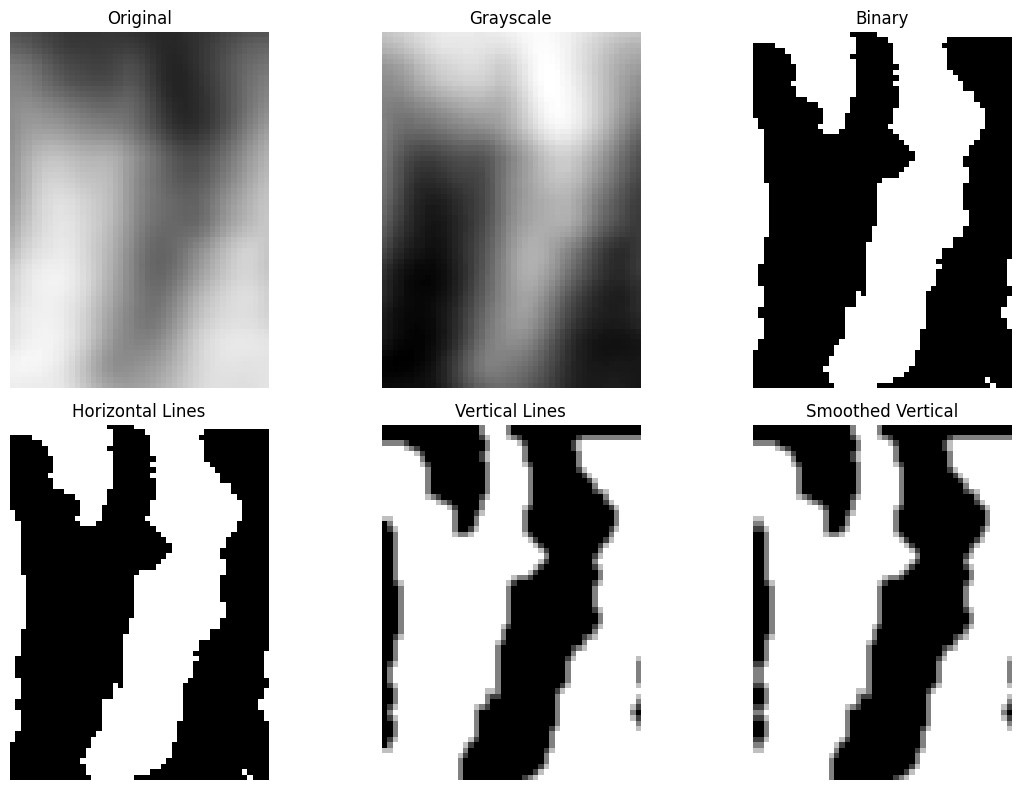

Топ-10 предсказаний:
1: Y (вероятность: 0.2801)
2: 2 (вероятность: 0.1730)
3: 9 (вероятность: 0.0611)
4: M (вероятность: 0.0609)
5: P (вероятность: 0.0556)
6: X (вероятность: 0.0436)
7: 8 (вероятность: 0.0414)
8: H (вероятность: 0.0380)
9: 0 (вероятность: 0.0329)
10: 1 (вероятность: 0.0279)


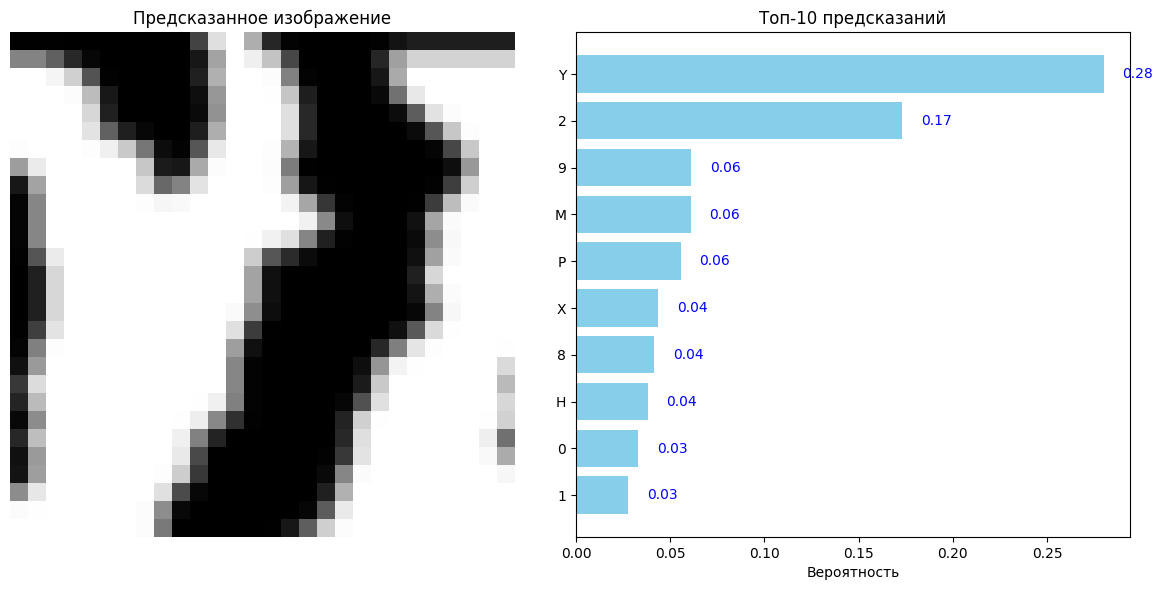

In [67]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

# Предполагается, что CLASSES и DEVICE определены ранее
# Например:
# CLASSES = ['A', 'B', 'C', ..., 'Z', '0', '1', ..., '9']
# DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Путь к изображению
image_path = "img/7-bad1.png"

# Определение трансформаций
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Изменяем размер до 28x28
    transforms.ToTensor(),        # Преобразуем в тензор
    transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация: среднее 0.5, стандартное отклонение 0.5
])

transform1 = transforms.Compose([
    transforms.ToTensor(),        # Преобразуем в тензор
    #transforms.Normalize(mean=[0.5], std=[0.5])  # Нормализация: среднее 0.5, стандартное отклонение 0.5
])

def preprocess_image(image_path):
    # Шаг 1: Загрузка изображения с помощью OpenCV
    src = cv.imread(image_path, cv.IMREAD_COLOR)
    assert src is not None, f"Ошибка при открытии изображения по пути: {image_path}"

    # Шаг 2: Преобразование в оттенки серого
    if len(src.shape) != 2:
        gray = cv.cvtColor(src, cv.COLOR_BGR2GRAY)
    else:
        gray = src

    # Инверсия цветов
    gray = cv.bitwise_not(gray)

    # Бинаризация изображения
    bw = cv.adaptiveThreshold(gray, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 15, -2)

    # Извлечение горизонтальных и вертикальных линий
    horizontal = np.copy(bw)
    vertical = np.copy(bw)

    # Обработка горизонтальных линий
    horizontal_size = horizontal.shape[1] // 30
    horizontalStructure = cv.getStructuringElement(cv.MORPH_RECT, (horizontal_size, 1))
    horizontal = cv.erode(horizontal, horizontalStructure)
    horizontal = cv.dilate(horizontal, horizontalStructure)

    # Обработка вертикальных линий
    vertical_size = vertical.shape[0] // 30
    verticalStructure = cv.getStructuringElement(cv.MORPH_RECT, (1, vertical_size))
    vertical = cv.erode(vertical, verticalStructure)
    vertical = cv.dilate(vertical, verticalStructure)

    # Инверсия вертикальных линий
    vertical = cv.bitwise_not(vertical)

    # Выделение краев
    edges = cv.adaptiveThreshold(vertical, 255, cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY, 3, -2)
    kernel = np.ones((2, 2), np.uint8)
    edges = cv.dilate(edges, kernel)

    # Сглаживание вертикальных линий
    smooth = np.copy(vertical)
    smooth = cv.blur(smooth, (2, 2))
    rows, cols = np.where(edges != 0)
    vertical[rows, cols] = smooth[rows, cols]

    # Финальная обработка: использование сглаженных вертикальных линий
    final_processed = vertical

    # (Опционально) Визуализация этапов обработки
    
    titles = ['Original', 'Grayscale', 'Binary', 'Horizontal Lines', 'Vertical Lines', 'Smoothed Vertical']
    images = [src, gray, bw, horizontal, vertical, smooth]

    plt.figure(figsize=(12, 8))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        plt.title(titles[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()
    

    # Преобразование обработанного изображения в формат PIL для применения трансформаций
    final_image = Image.fromarray(final_processed)

    # Применение трансформаций
    image_tensor = transform(final_image)

    # Добавление batch dimension
    image_tensor = image_tensor.unsqueeze(0)

    return image_tensor

# Загрузка и обработка изображения
image_tensor = preprocess_image(image_path).to(DEVICE)

# Обработка символов (предполагается, что transformed_symbols определен)
# char_tensor = transform1(transformed_symbols[3]).unsqueeze(0).to(DEVICE)

# Загрузка модели (предполагается, что модель уже определена)
# model = SimpleCNN(len(CLASSES)).to(DEVICE)
# Загрузка весов модели
# model.load_state_dict(torch.load(SAVE_PATH, map_location=DEVICE))
# model.eval()

# Убедитесь, что модель находится в режиме оценки
model.eval()

# Добавление вывода изображения и графика топ-10 предсказаний
def plot_image_and_predictions(image_tensor, classes):
    """
    Отображает изображение и график топ-10 предсказаний модели.
    
    :param image_tensor: Тензор изображения после предобработки.
    :param classes: Список названий классов.
    """
    # Предсказание
    with torch.no_grad():
        output = model(image_tensor)  # Получение выхода модели
        probabilities = torch.softmax(output, dim=1)  # Преобразование выходов в вероятности
        top10_probabilities, top10_indices = torch.topk(probabilities, 10, dim=1)  # Получение топ-10
        
        top_probs = top10_probabilities.squeeze(0)  # Удаление batch-дименшена
        top_indices = top10_indices.squeeze(0)      # Удаление batch-дименшена

    print("Топ-10 предсказаний:")
    for i in range(10):
        predicted_class = top_indices[i].item()
        probability = top_probs[i].item()
        print(f"{i + 1}: {CLASSES[predicted_class]} (вероятность: {probability:.4f})")
        
    # Обратная нормализация для отображения изображения
    unnormalize = transforms.Normalize(
        mean=[-0.5 / 0.5],
        std=[1 / 0.5]
    )
    image_tensor_unnorm = unnormalize(image_tensor.squeeze(0)).cpu().numpy()
    
    # Переводим тензор в формат [H, W]
    image_np = image_tensor_unnorm.squeeze(0)
    image_np = np.clip(image_np, 0, 1)  # Ограничиваем значения для корректного отображения
    
    # Получение топ-10 классов и их вероятностей
    top_classes = [classes[idx] for idx in top_indices]
    top_probs = top_probs.cpu().numpy()
    
    # Создание фигуры с двумя подграфиками
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    # Отображение изображения
    ax1.imshow(image_np, cmap='gray')
    ax1.set_title("Предсказанное изображение")
    ax1.axis('off')
    
    # Отображение графика топ-10 предсказаний
    ax2.barh(range(10), top_probs, color='skyblue')  # Инвертируем для отображения сверху вниз
    ax2.set_yticks(range(10))
    ax2.set_yticklabels(top_classes)
    ax2.invert_yaxis()  # Самый высокий показатель сверху
    ax2.set_xlabel('Вероятность')
    ax2.set_title('Топ-10 предсказаний')
    
    # Добавление вероятностей на график
    for i, v in enumerate(top_probs):
        ax2.text(v + 0.01, i, f"{v:.2f}", color='blue', va='center')
    
    plt.tight_layout()
    plt.show()

# Вызов функции для отображения
plot_image_and_predictions(image_tensor, CLASSES)


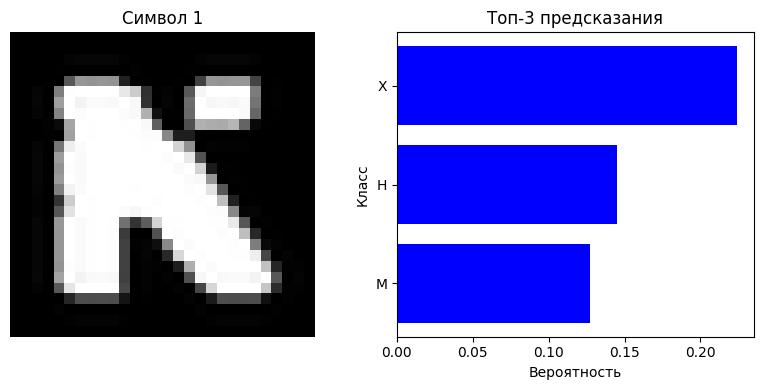

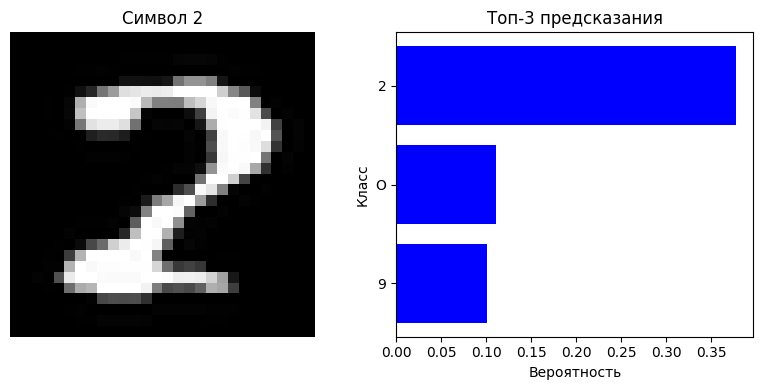

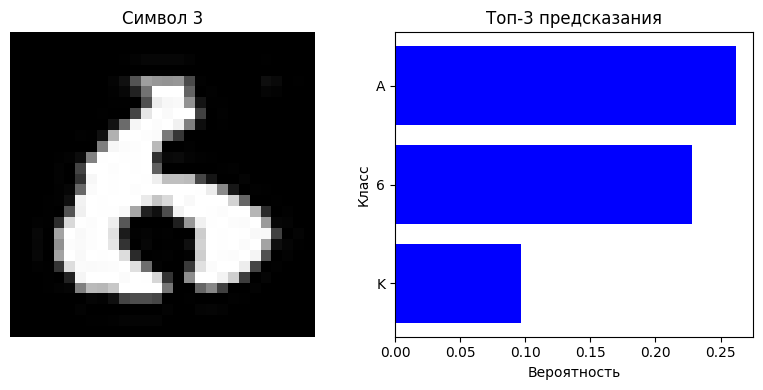

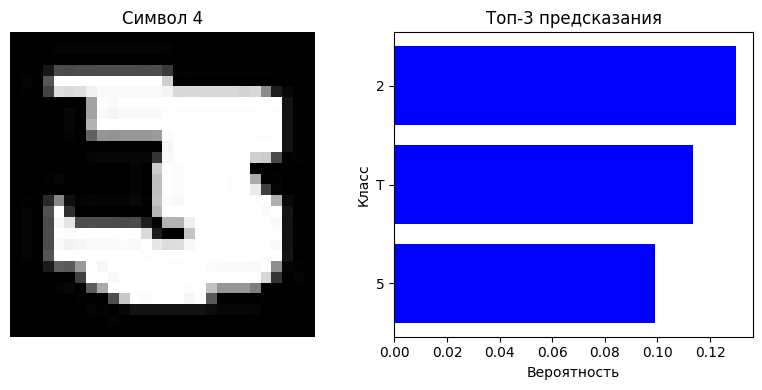

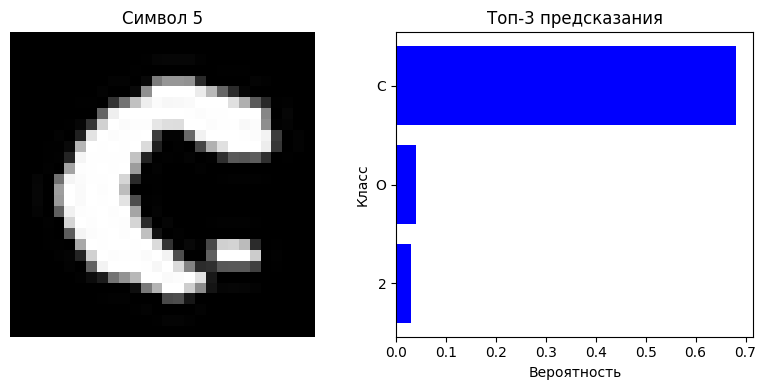

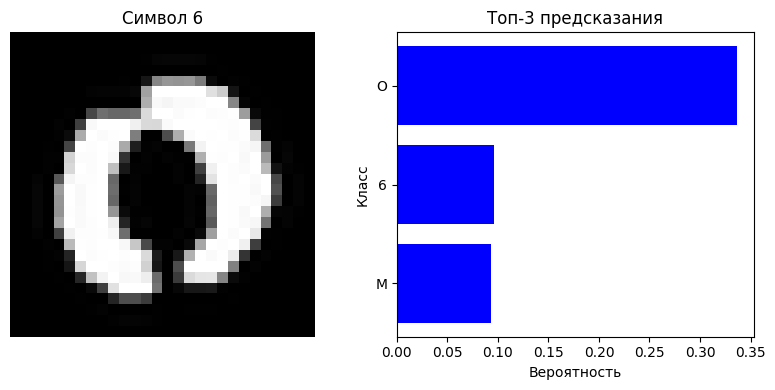

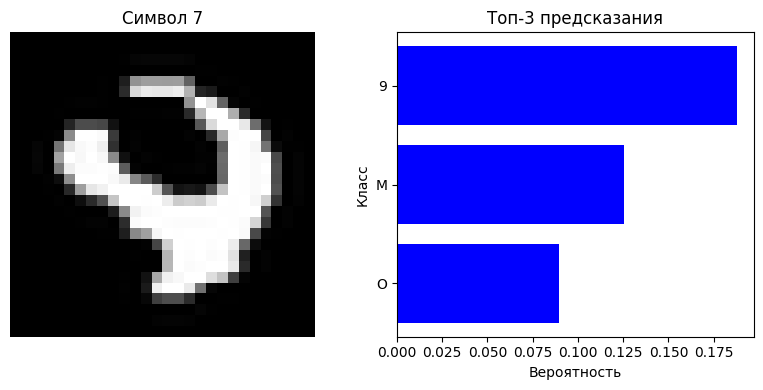

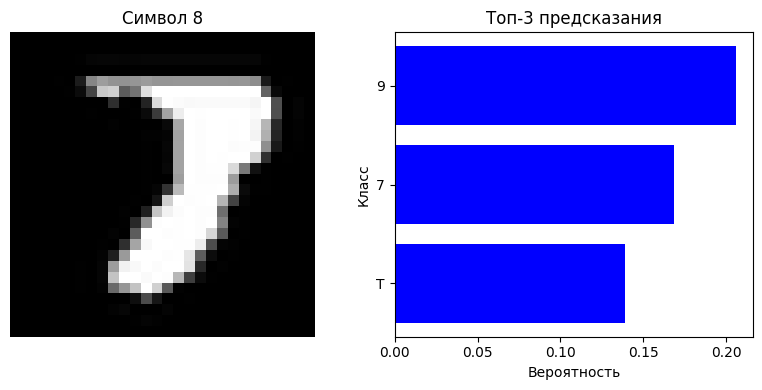

In [34]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import cv2

# Классы символов
CLASSES = "ABEKMHOPCTYX0123456789"
NUM_CLASSES = len(CLASSES)

# Загрузка модели и весов
DEVICE = "cpu"  # Или "cuda", если доступен GPU
model = SimpleCNN(NUM_CLASSES).to(DEVICE)
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))  # Загрузка весов
model.eval()

# Преобразование для входных данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Нормализация значений пикселей
])

# Функция для получения топ-3 предсказаний
def get_top_predictions(output, top_k=3):
    probabilities = torch.softmax(output, dim=1).squeeze()  # Преобразование в вероятности
    top_probs, top_indices = torch.topk(probabilities, top_k)
    return top_probs.tolist(), [CLASSES[idx] for idx in top_indices.tolist()]

# Функция для добавления отступов
def add_padding(img, padding=10):
    """
    Добавляет отступы вокруг изображения.

    :param img: Массив numpy с изображением символа.
    :param padding: Количество пикселей для отступа.
    :return: Изображение с отступами.
    """
    pil_img = Image.fromarray(img)
    padded_img = ImageOps.expand(pil_img, border=padding, fill=0)
    return np.array(padded_img)

# Функция для утончения линий
def thin_lines(img, kernel_size=(2, 2), iterations=1):
    """
    Утончает линии на изображении с помощью морфологической операции эрозии.

    :param img: Массив numpy с изображением символа.
    :param kernel_size: Размер ядра эрозии.
    :param iterations: Количество итераций эрозии.
    :return: Изображение с утонченными линиями.
    """
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    eroded_img = cv2.erode(img, kernel, iterations=iterations)
    return eroded_img

# Функция распознавания символов с выводом графиков
# Функция для изменения размера изображения
# Функция для изменения размера изображения
def resize_to_model_input(img, target_size=(28, 28)):
    """
    Изменяет размер изображения до требуемого для модели.

    :param img: Массив numpy с изображением символа.
    :param target_size: Размер, до которого нужно привести изображение.
    :return: Изображение с измененным размером.
    """
    pil_img = Image.fromarray(img)
    resized_img = pil_img.resize(target_size, Image.Resampling.LANCZOS)  # Используем LANCZOS вместо ANTIALIAS
    return np.array(resized_img)

# Остальной код остается без изменений


# Функция распознавания символов с исправлением размера
def recognize_and_plot_characters(characters, model, device="cpu", padding=5):
    """
    Распознает символы из списка изображений characters и строит графики топ-3 предсказаний.

    :param characters: Список символов (массивы numpy 28x28).
    :param model: Загруженная модель для распознавания.
    :param device: Устройство для вычислений ("cpu" или "cuda").
    :param padding: Отступы вокруг символа.
    """
    for i, char in enumerate(characters):
        # Добавление отступов
        char_padded = add_padding(char, padding=padding)

        
        char_selective = selective_dilation(char_padded, distance_threshold=4, iterations=1)
        char_selective = thin_lines(char_selective, kernel_size=(2,2), iterations=1)
        # Изменение размера для модели
        char_resized = resize_to_model_input(char_selective, target_size=(28, 28))

        # Преобразование символа в тензор
        char_tensor = transform(char_resized).unsqueeze(0).to(device)  # Добавляем batch размерности
        
        # Прогон через модель
        with torch.no_grad():
            output = model(char_tensor)
            top_probs, top_classes = get_top_predictions(output)

        # Вывод символа и графика топ-3 предсказаний
        plt.figure(figsize=(8, 4))

        # Символ
        plt.subplot(1, 2, 1)
        plt.imshow(char_resized, cmap='gray')
        plt.axis('off')
        plt.title(f"Символ {i + 1}")

        # Топ-3 предсказания
        plt.subplot(1, 2, 2)
        plt.barh(top_classes, top_probs, color='blue')
        plt.xlabel("Вероятность")
        plt.ylabel("Класс")
        plt.title("Топ-3 предсказания")
        plt.gca().invert_yaxis()  # Инвертируем ось, чтобы лучший класс был сверху

        plt.tight_layout()
        plt.show()


# Использование функции
if 'characters' in locals() and len(characters) > 0:
    recognize_and_plot_characters(characters, model, device=DEVICE, padding=5)
else:
    print("Список characters пуст.")
